# `Case Study on Telecom Churn Issue`
This assignment's goal is to create a categorization model that should do two things:
It will be applied to forecast the likelihood of churn for valuable prepaid customers.
It will be applied to determine significant variables that have high churn prediction power.


## Reading and comprehending data, importing packages

In [1]:
# Loading Packages
import numpy as np
import pandas as pd
from datetime import datetime as dt
import scipy.stats as stats
from scipy.stats import norm, skew 
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')
#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 

In [2]:
#examining the dataset of data
data = pd.read_csv("telecom_churn_data.csv",  sep = ',',encoding = "ISO-8859-1")
data.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109           0.000           0.000           0.000   
1     7001865778        109           0.000           0.000           0.000   
2     7001625959        109           0.000           0.000           0.000   
3     7001204172        109           0.000           0.000           0.000   
4     7000142493        109           0.000           0.000           0.000   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9  arpu_6  ...  sachet_3g_9  fb_user_6  fb_user_7  \
0            9/30/2014 197.385  ...            0      1.000      1.000   
1            9/30/2014  34.047  ...            0        NaN      1.000   
2            9/30/2014 167.690  ...            0        NaN        NaN   
3            9/30/2014 221.338  ...            0        NaN        NaN   
4            9/30/2014 261.636  ...            0      0.000        NaN   

   fb_user_8  fb_user_9   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  sep_vbc_3g  
0      1.000        NaN   968      30.400       0.000     101.200       3.580  
1      1.000        NaN  1006       0.000       0.000       0.000       0.000  
2        NaN      1.000  1103       0.000       0.000       4.170       0.000  
3        NaN        NaN  2491       0.000       0.000       0.000       0.000  
4        NaN        NaN  1526       0.000       0.000       0.000       0.000  

[5 rows x 226 columns]

In [3]:
# Verifying the data types
data.dtypes

mobile_number       int64
circle_id           int64
loc_og_t2o_mou    float64
std_og_t2o_mou    float64
loc_ic_t2o_mou    float64
                   ...   
aon                 int64
aug_vbc_3g        float64
jul_vbc_3g        float64
jun_vbc_3g        float64
sep_vbc_3g        float64
Length: 226, dtype: object

In [4]:
# Examining the dataframe's form
print(data.shape)

(99999, 226)


## Step 2: Data Preparation

### Managing The process of eliminating duplicate rows

In [5]:
# remove duplicate rows
data.drop_duplicates(subset='mobile_number')
data.shape

(99999, 226)

*None dup. rows*

### Dropping Unnecessary Columns NOT needed for Analysis

In [6]:
# Finding out if there is a column that has just null values
data.isnull().all(axis=0).any()

False

In [7]:
# removing all columns that have values of zero
data.loc[:, (data != 0).any(axis=0)]
data.shape

(99999, 226)

In [8]:
#Eliminate columns with a single, distinct value.
data= data.loc[:,data.nunique()!=1]
data.shape

(99999, 210)

The month and year of each date column shall be in part identical. There's only one part of the day that's different. Therefore, for all the dates columns*, extract the day from that date.

In [9]:
# Locating the dataframe's date columns(type = categorical)
date_columns = data.dtypes[data.dtypes == "object"].index
date_columns

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_9', 'date_of_last_rech_data_6',
       'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
       'date_of_last_rech_data_9'],
      dtype='object')

In [10]:
# Taking the "day" out of the date
data['date_of_last_rech_6'] =  pd.to_datetime(data['date_of_last_rech_6'], format='%m/%d/%Y').dt.day
data['date_of_last_rech_7'] =  pd.to_datetime(data['date_of_last_rech_7'], format='%m/%d/%Y').dt.day
data['date_of_last_rech_8'] =  pd.to_datetime(data['date_of_last_rech_8'], format='%m/%d/%Y').dt.day
data['date_of_last_rech_9'] =  pd.to_datetime(data['date_of_last_rech_9'], format='%m/%d/%Y').dt.day

data['date_of_last_rech_data_6'] =  pd.to_datetime(data['date_of_last_rech_data_6'], format='%m/%d/%Y').dt.day
data['date_of_last_rech_data_7'] =  pd.to_datetime(data['date_of_last_rech_data_7'], format='%m/%d/%Y').dt.day
data['date_of_last_rech_data_8'] =  pd.to_datetime(data['date_of_last_rech_data_8'], format='%m/%d/%Y').dt.day
data['date_of_last_rech_data_9'] =  pd.to_datetime(data['date_of_last_rech_data_9'], format='%m/%d/%Y').dt.day

data[date_columns].dtypes

date_of_last_rech_6         float64
date_of_last_rech_7         float64
date_of_last_rech_8         float64
date_of_last_rech_9         float64
date_of_last_rech_data_6    float64
date_of_last_rech_data_7    float64
date_of_last_rech_data_8    float64
date_of_last_rech_data_9    float64
dtype: object

In [11]:
# examining the date columns following conversion
data[date_columns].head()

date_of_last_rech_6  date_of_last_rech_7  date_of_last_rech_8  \
0               21.000               16.000                8.000   
1               29.000               31.000               28.000   
2               17.000               24.000               14.000   
3               28.000               31.000               31.000   
4               26.000               28.000                9.000   

   date_of_last_rech_9  date_of_last_rech_data_6  date_of_last_rech_data_7  \
0               28.000                    21.000                    16.000   
1               30.000                       NaN                    25.000   
2               29.000                       NaN                       NaN   
3               30.000                       NaN                       NaN   
4               28.000                     4.000                       NaN   

   date_of_last_rech_data_8  date_of_last_rech_data_9  
0                     8.000                       NaN  
1                    10.000                       NaN  
2                       NaN                    17.000  
3                       NaN                       NaN  
4                       NaN                       NaN

In [12]:
# determining the overall number and percentage of null values in each dataframe column.
cols = data.columns
num_cols = data._get_numeric_data().columns
list(set(cols) - set(num_cols))

[]

### Managing NA's

In [13]:
# Checking for total count and percentage of null values in all columns of the dataframe.

total = pd.DataFrame(data.isnull().sum().sort_values(ascending=False), columns=['Total'])
percentage = pd.DataFrame(round(100*(data.isnull().sum()/data.shape[0]),2).sort_values(ascending=False)\
                          ,columns=['Percentage'])
pd.concat([total, percentage], axis = 1)

Total  Percentage
max_rech_data_6   74846      74.850
fb_user_6         74846      74.850
count_rech_3g_6   74846      74.850
count_rech_2g_6   74846      74.850
night_pck_user_6  74846      74.850
...                 ...         ...
max_rech_amt_9        0       0.000
max_rech_amt_8        0       0.000
max_rech_amt_7        0       0.000
max_rech_amt_6        0       0.000
sep_vbc_3g            0       0.000

[210 rows x 2 columns]

### Using rows to visualize the occurrence of Null values in the columns

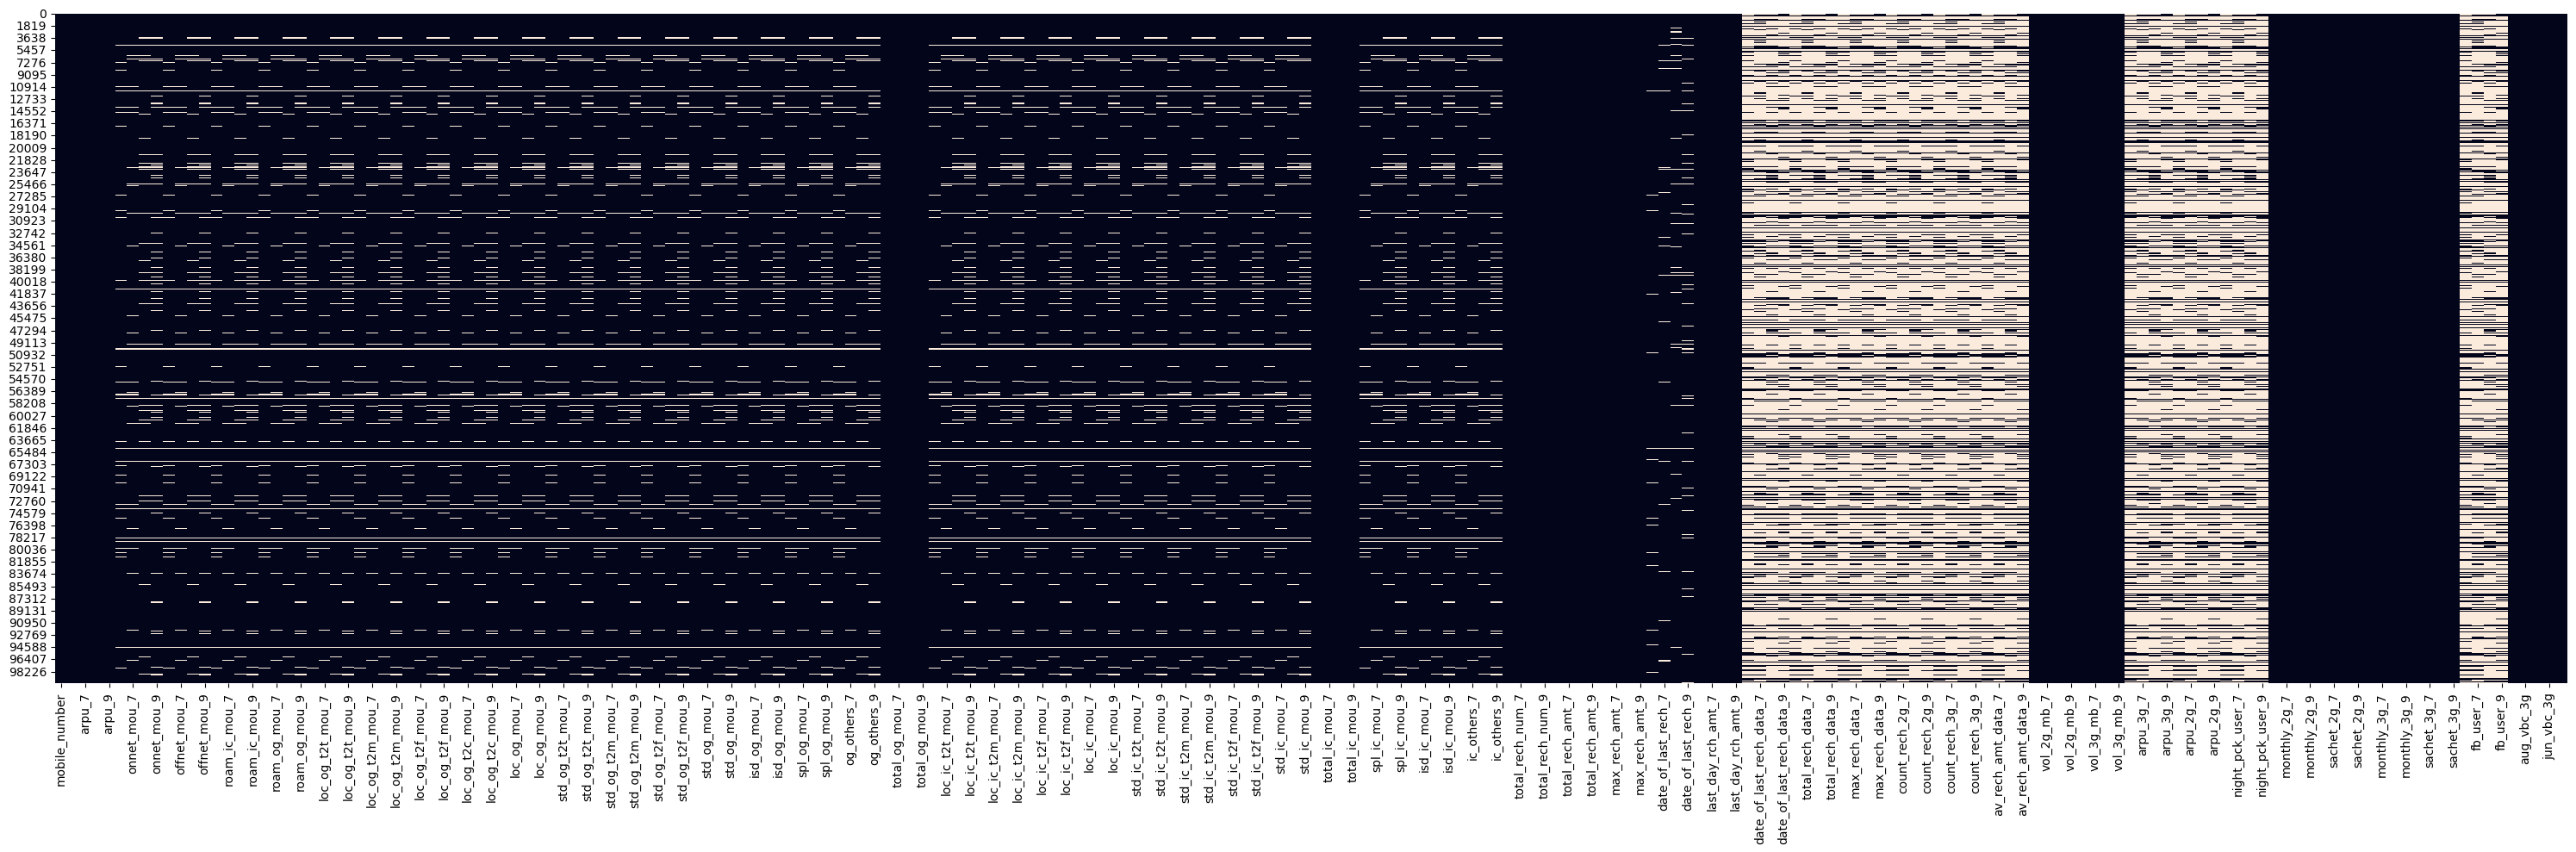

In [14]:
plt.figure(figsize=(30,10))
sns.heatmap(data.isnull(), cbar=False)

plt.tight_layout()
plt.show()

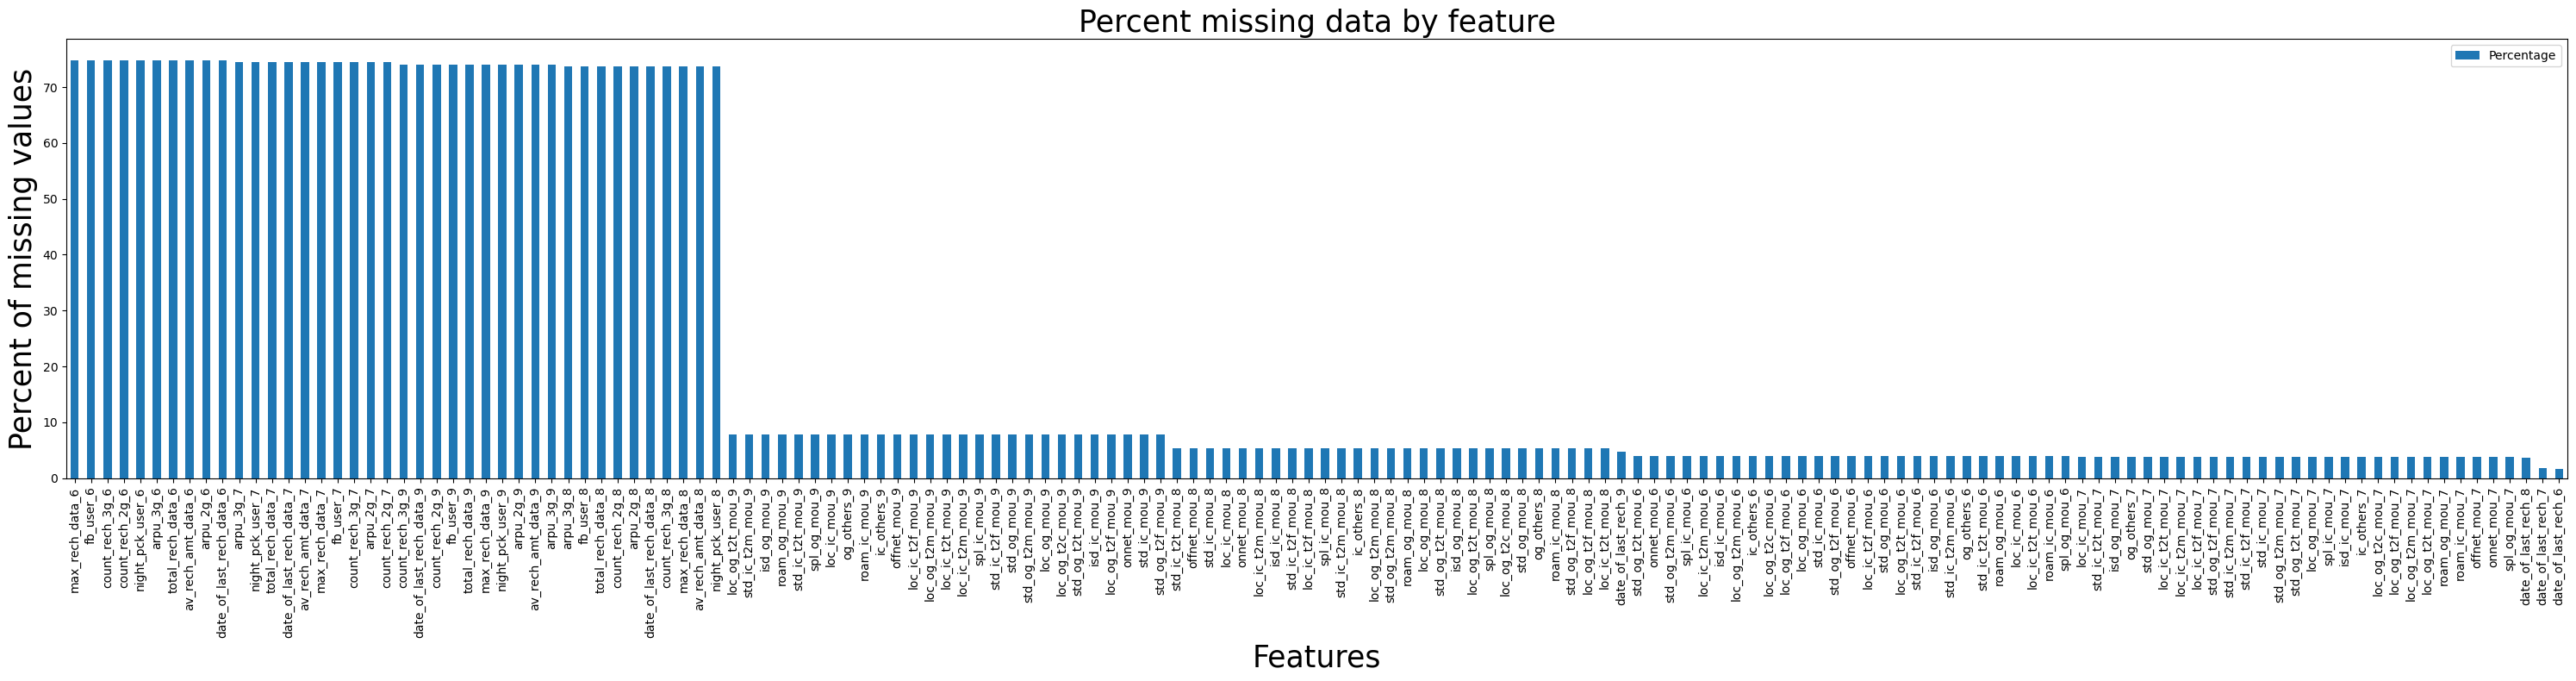

In [15]:
# total of null values 
percentage = percentage.loc[percentage['Percentage'] > 0]
percentage.plot.bar(figsize=(30,8))
plt.xlabel('Features', fontsize=25)
plt.ylabel('Percent of missing values', fontsize=25)
plt.title('Percent missing data by feature', fontsize=25)
plt.tight_layout()
plt.show()

#### Apply 0 to every NAN value in accordance with design judgment.

In [16]:
# choosing the columns that have null values
columns_null = total.loc[total['Total'] >= 0].index
columns_null

Index(['max_rech_data_6', 'fb_user_6', 'count_rech_3g_6', 'count_rech_2g_6',
       'night_pck_user_6', 'arpu_3g_6', 'total_rech_data_6',
       'av_rech_amt_data_6', 'arpu_2g_6', 'date_of_last_rech_data_6',
       ...
       'vol_2g_mb_6', 'last_day_rch_amt_8', 'total_rech_amt_9',
       'last_day_rch_amt_7', 'last_day_rch_amt_6', 'max_rech_amt_9',
       'max_rech_amt_8', 'max_rech_amt_7', 'max_rech_amt_6', 'sep_vbc_3g'],
      dtype='object', length=210)

In [17]:
#Filling all null values with 0
data[columns_null] = data[columns_null].fillna(0)

In [18]:
# determining the overall number and percentage of null values in each dataframe column.

total = pd.DataFrame(data.isnull().sum().sort_values(ascending=False), columns=['Total'])
percentage = pd.DataFrame(round(100*(data.isnull().sum()/data.shape[0]),2).sort_values(ascending=False)\
                          ,columns=['Percentage'])
pd.concat([total, percentage], axis = 1).head()

Total  Percentage
mobile_number            0       0.000
count_rech_3g_6          0       0.000
date_of_last_rech_6      0       0.000
date_of_last_rech_7      0       0.000
date_of_last_rech_8      0       0.000

### Recognizing High-Value Consumers

Customers classified as High-Value are those who have refilled to a value greater than or equal to X, where X represents the 70th percentile of the average amount refilled during the first two months (the good phase), June and July.

In [19]:
# Monthly call and data recharge totals are calculated as follows: total call recharge amount + average data recharge amount * total no.of data recharges
data['total_data_and_call_rech_6'] = data["total_rech_amt_6"] + data['av_rech_amt_data_6']*data['total_rech_data_6']
data['total_data_and_call_rech_7'] = data['total_rech_amt_7'] + data['av_rech_amt_data_7']*data['total_rech_data_7']
data['total_data_and_call_rech_8'] = data['total_rech_amt_8'] + data['av_rech_amt_data_8']*data['total_rech_data_8']

# Total call and data recharged in June plus total call and data recharged in July equals the average recharge amount for June and July.
data['avg_rech_6_&_7'] = (data['total_data_and_call_rech_6'] + data['total_data_and_call_rech_7'])/2
data[['total_rech_amt_6','av_rech_amt_data_6','total_rech_data_6','total_data_and_call_rech_6','total_rech_amt_7','av_rech_amt_data_7','total_rech_data_7','total_data_and_call_rech_7','avg_rech_6_&_7','total_data_and_call_rech_8']].head()

total_rech_amt_6  av_rech_amt_data_6  total_rech_data_6  \
0               362             252.000              1.000   
1                74               0.000              0.000   
2               168               0.000              0.000   
3               230               0.000              0.000   
4               196              56.000              1.000   

   total_data_and_call_rech_6  total_rech_amt_7  av_rech_amt_data_7  \
0                     614.000               252             252.000   
1                      74.000               384             154.000   
2                     168.000               315               0.000   
3                     230.000               310               0.000   
4                     252.000               350               0.000   

   total_rech_data_7  total_data_and_call_rech_7  avg_rech_6_&_7  \
0              1.000                     504.000         559.000   
1              1.000                     538.000         306.000   
2              0.000                     315.000         241.500   
3              0.000                     310.000         270.000   
4              0.000                     350.000         301.000   

   total_data_and_call_rech_8  
0                     504.000  
1                     383.000  
2                     116.000  
3                     601.000  
4                     287.000

In [20]:
# X The average recharge amount for the first two months, June and July, is represented by the 70th percentile, or X.
X = data['avg_rech_6_&_7'].quantile(0.7)
X

478.0

In [21]:
# Sorting valuable clientele
data = data.loc[data['avg_rech_6_&_7'] >= data['avg_rech_6_&_7'].quantile(0.7)]
data.shape

(30001, 214)

In [22]:
# Eliminating every unnecessary column
columns_drop = ['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8'
                 ,'total_rech_data_6','total_rech_data_7','total_rech_data_8']
columns_drop

['total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8']

In [23]:
data = data.drop(columns_drop, axis=1)
data.shape

(30001, 205)

### The first three months' average recharge amount

### Churners*

**Churners are those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase(4th month).*Churners are those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase(4th month).*

In [24]:
# column selection for churn computation
churn_columns = ['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']
churn_columns

['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']

In [25]:
# Compiling September's total call and data costs
data['total_calls_&_data_9'] = data['total_ic_mou_9'] + data['total_og_mou_9'] + data['vol_2g_mb_9'] + data['vol_3g_mb_9']
data[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9','total_calls_&_data_9']].head()  

total_ic_mou_9  total_og_mou_9  vol_2g_mb_9  vol_3g_mb_9  \
0            0.000           0.000        0.000        0.000   
7            0.000           0.000        0.000        0.000   
8           34.910         142.180        0.000        0.000   
21         252.610        1031.530        0.000        0.000   
23         127.480         127.630       13.930      314.740   

    total_calls_&_data_9  
0                  0.000  
7                  0.000  
8                177.090  
21              1284.140  
23               583.780

In [26]:
# Compute Churn. Churn if total amount = 0, otherwise do not
data['churn'] = data['total_calls_&_data_9'].apply(lambda x:1 if x==0 else 0)
data[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9','total_calls_&_data_9','churn']].head()

total_ic_mou_9  total_og_mou_9  vol_2g_mb_9  vol_3g_mb_9  \
0            0.000           0.000        0.000        0.000   
7            0.000           0.000        0.000        0.000   
8           34.910         142.180        0.000        0.000   
21         252.610        1031.530        0.000        0.000   
23         127.480         127.630       13.930      314.740   

    total_calls_&_data_9  churn  
0                  0.000      1  
7                  0.000      1  
8                177.090      0  
21              1284.140      0  
23               583.780      0

### Eliminate every feature from the Churn Phase (fourth month)*.

In [27]:
# eliminating every attribute (all attributes with "_9," etc.) that corresponds to the churn phase.
cols = [c for c in data.columns if c[-2:] != '_9']
data=data[cols]
data = data.drop('sep_vbc_3g', axis=1)
data.shape

(30001, 154)

In [28]:
# reexamining the dataframe's total count and percentage of null values in each of its columns.
total = pd.DataFrame(data.isnull().sum().sort_values(ascending=False), columns=['Total'])
percentage = pd.DataFrame(round(100*(data.isnull().sum()/data.shape[0]),2).sort_values(ascending=False)\
                          ,columns=['Percentage'])
pd.concat([total, percentage], axis = 1).head()

Total  Percentage
mobile_number                 0       0.000
date_of_last_rech_data_8      0       0.000
date_of_last_rech_7           0       0.000
date_of_last_rech_8           0       0.000
last_day_rch_amt_6            0       0.000

In [29]:
data.to_csv("data1.csv", sep=',')

## Data Visualisation

### Distribution of the total recharge for Churn and Churn Customers in separate months

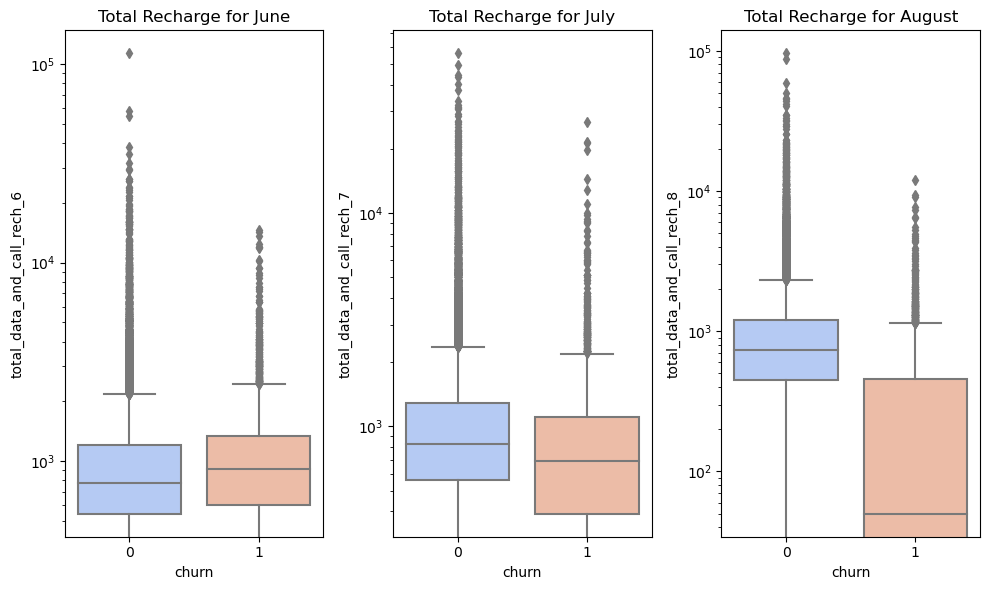

In [30]:
# To make the figure more horizontal, slightly adjust its size.
plt.figure(figsize=(10, 6), dpi=100, facecolor='w', edgecolor='k', frameon='True')

# subplot 1
plt.subplot(1, 3, 1)
sns.boxplot(x='churn', y='total_data_and_call_rech_6', palette='coolwarm', data=data)
# setting y scale as log y
plt.yscale('log')
# plot title
plt.title("Total Recharge for June")

# subplot 2
plt.subplot(1, 3, 2)
sns.boxplot(x='churn', y='total_data_and_call_rech_7', palette='coolwarm', data=data)
# setting y scale as log y
plt.yscale('log')
# plot title
plt.title("Total Recharge for July")

# subplot 3
plt.subplot(1, 3, 3)
sns.boxplot(x='churn', y='total_data_and_call_rech_8', palette='coolwarm', data=data)
# setting y scale as log y
plt.yscale('log')
# plot title
plt.title("Total Recharge for August")

# Subplot parameters should be automatically adjusted so that the subplotS fits inside the figure area.
plt.tight_layout()

# display 
plt.show()

####  we can see that the majority of non-churn customers have an increasing trend in the total recharge they make over the months after taking out a network connection.

The bulk of both Churn and Non-Churn customers recharged for almost the same amount in June, the first month of the good phase.The bulk of non-churn customers recharged more overall in July than did Churn customers during the second month of the good phase.The majority of Non-Churn customers, however, recharged significantly more overall during the August action phase than did Churn customers.

### Date of August Last Call Recharge for Customers Who Don'tChurn and Who Don't

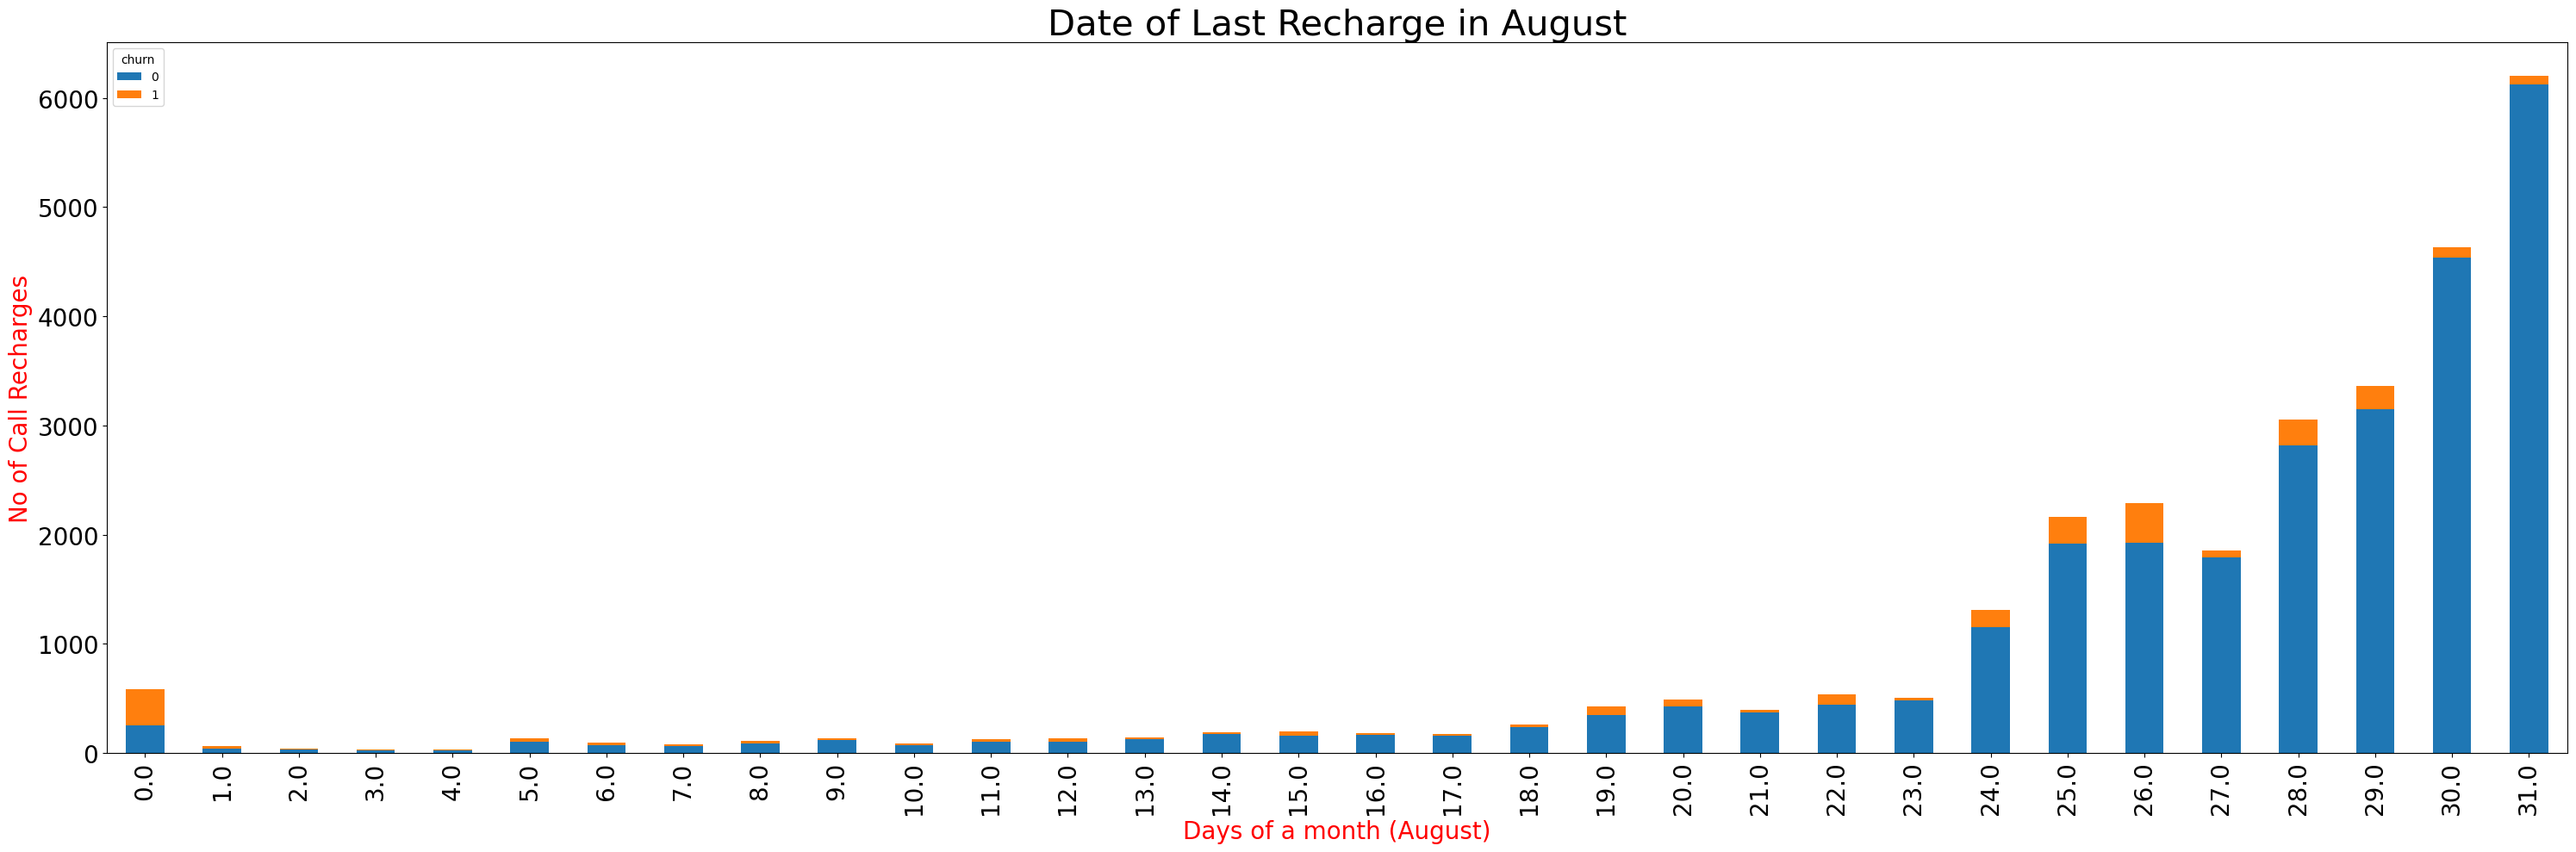

In [31]:
data.groupby(["date_of_last_rech_8", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10), fontsize = 20) 
# plot title
plt.title("Date of Last Recharge in August", fontsize = 30)
# plot x axis label
plt.xlabel('Days of a month (August)', fontsize = 20, color='r')
# plot y axis label
plt.ylabel('No of Call Recharges', fontsize = 20, color='r')

# Subplot parameters should be automatically adjusted so that the subplotS fits inside the figure area.
plt.tight_layout()

# display the plot
plt.show()

*we can see that there is a more or less gradual increasing trend in the last call recharge for both churn and non-churn customers at the end of the month compared to the early days of the month.

This pattern is also evident in other months.

### Date of August Last Data Recharge for Customers Who Don'tChurn and Who Don't

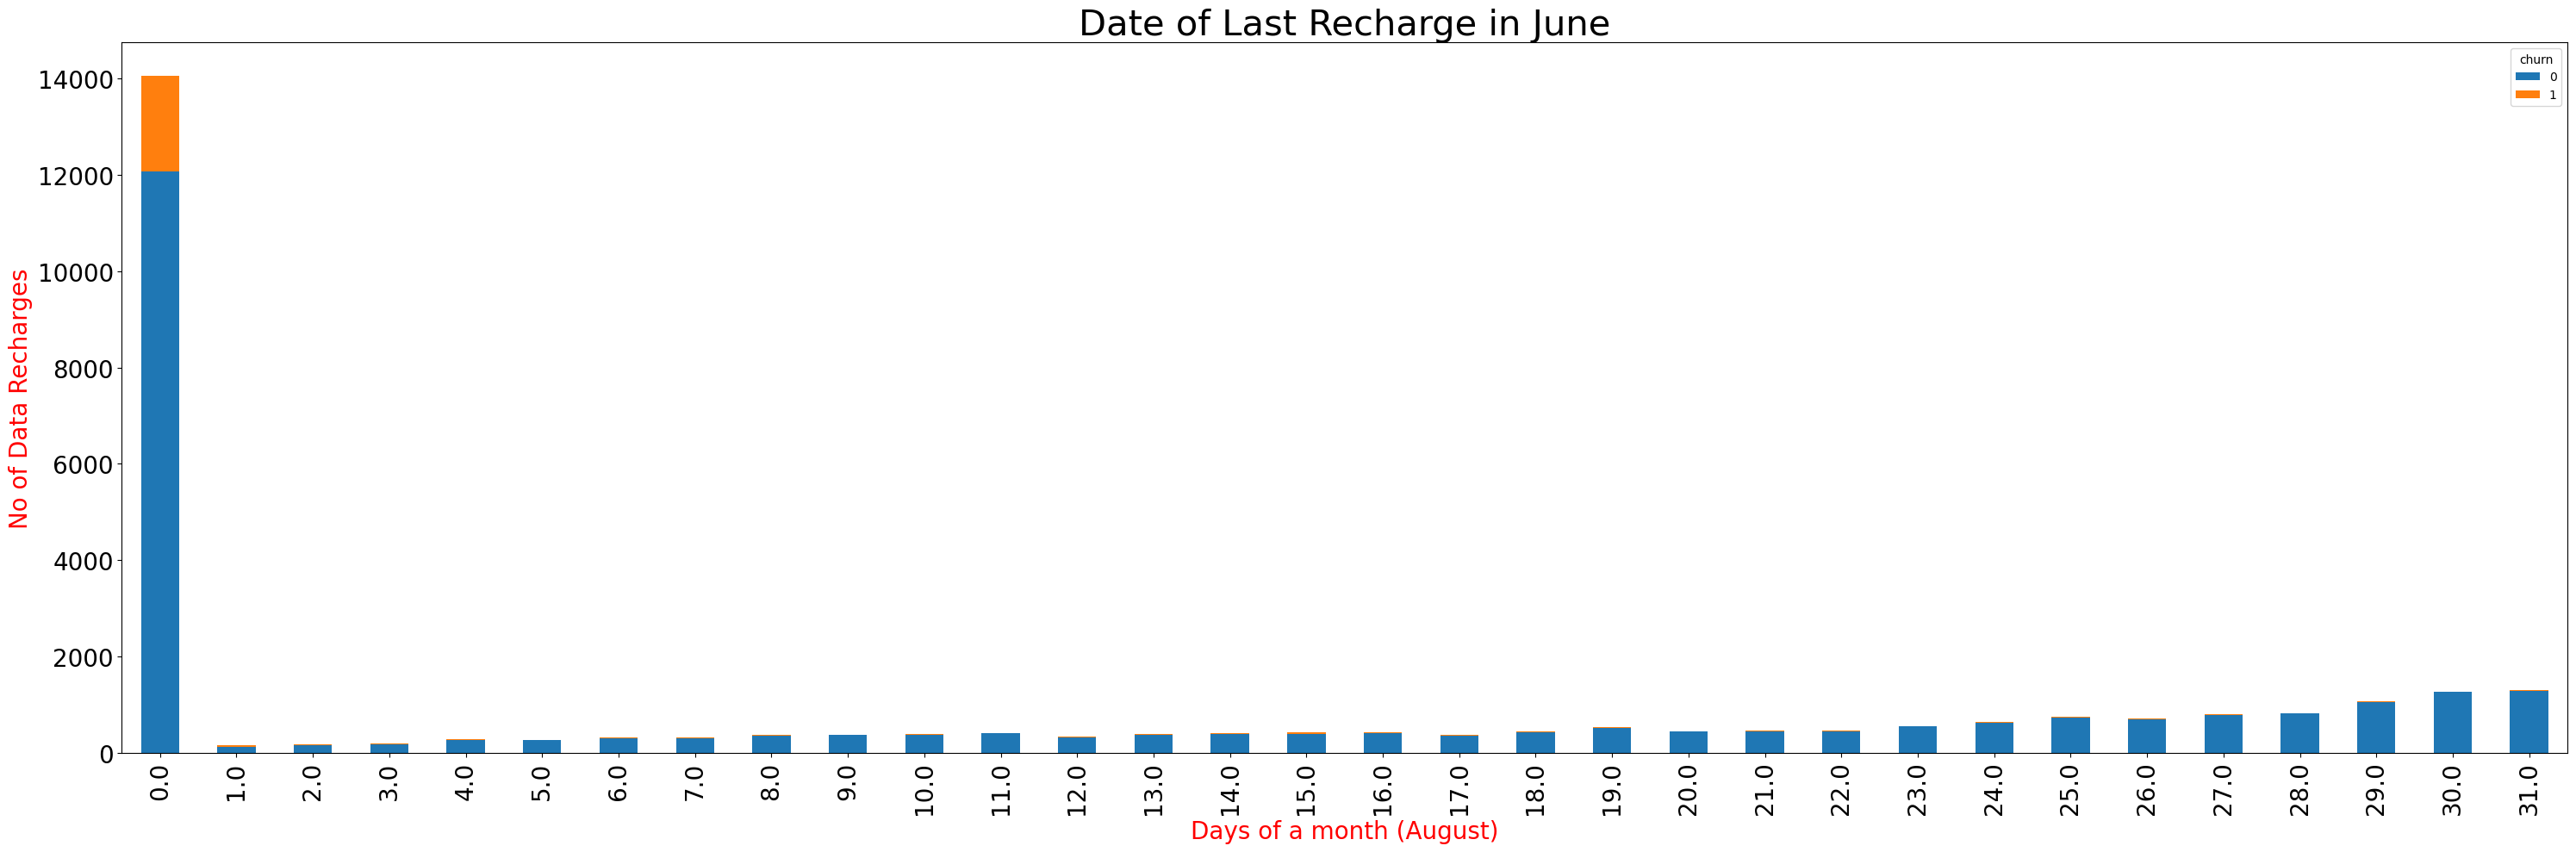

In [32]:
data.groupby(["date_of_last_rech_data_8", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10), fontsize = 20) 
# plot title
plt.title("Date of Last Recharge in June", fontsize = 30)
# plot x axis label
plt.xlabel('Days of a month (August)', fontsize = 20, color='r')
# plot y axis label
plt.ylabel('No of Data Recharges', fontsize = 20, color='r')

# Subplot parameters should be automatically adjusted so that the subplotS fits inside the figure area.
plt.tight_layout()

# display the plot
plt.show()

The above plot shows that there is a miniscile increasing trend for both churn and non-churn customers' last data recharge for a given month. * The high reading, which corresponds to 0 days, represents customers who have not recharged their data for the month.
This pattern is also evident in other months.

### Customers' ages on the network

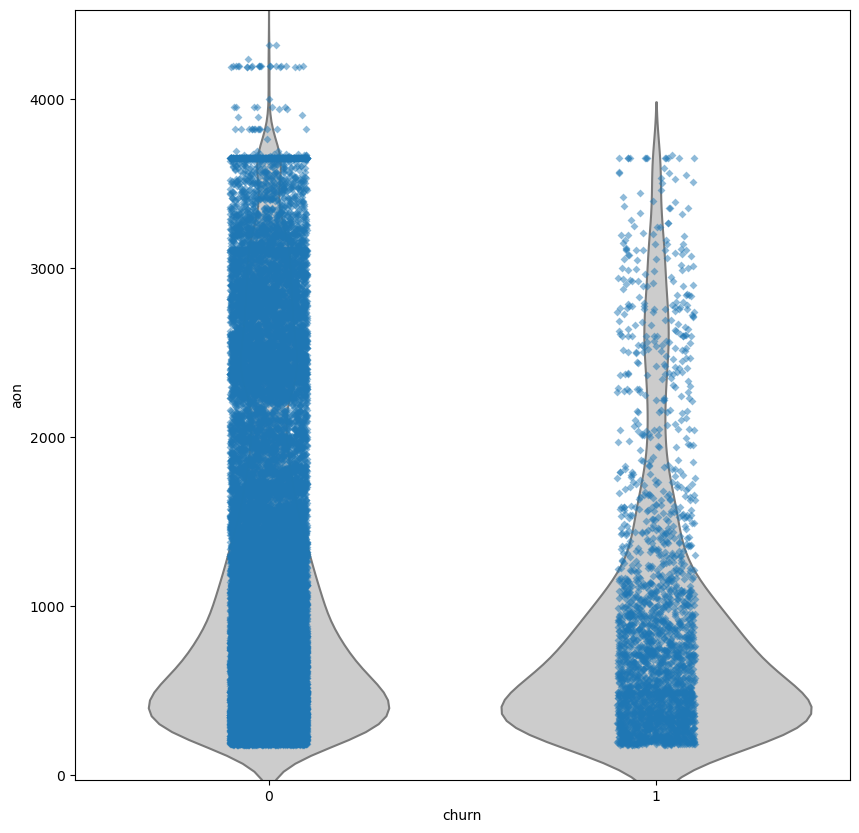

In [33]:
plt.subplots(figsize=(10,10))

g = sns.violinplot(x="churn", y="aon", data=data, inner=None,color="0.8")
g = sns.stripplot(x="churn", y="aon", data=data, jitter=True, marker="D", size=4, alpha=0.5,edgecolor="gray")

#g.set_yticks(np.arange(0,80,5))
#plt.yscale('log')
g
plt.show()

The chart shows that the bars widen below 1000 days. However, if we look at customers who have left, the number of them is highest during the first several months. However, as the network ages and the plot narrows, they progressively begin to give up.

### Correlation between significant churn indicators

In [34]:
cols = [c for c in data.columns if c[-2:] == '_8']
data_8=data[cols]
data_8.head()

arpu_8  onnet_mou_8  offnet_mou_8  roam_ic_mou_8  roam_og_mou_8  \
0   213.803        0.000         0.000          0.000          0.000   
7  3171.480       52.290       325.910         31.640         38.060   
8   137.362       35.080       136.480          0.000          0.000   
21  637.760       85.140       983.390          0.000          0.000   
23  366.966       33.580       205.890          0.000          0.000   

    loc_og_t2t_mou_8  loc_og_t2m_mou_8  loc_og_t2f_mou_8  loc_og_t2c_mou_8  \
0              0.000             0.000             0.000             0.000   
7             40.280           162.280            53.230             0.000   
8             12.490            50.540             0.000             7.150   
21            23.340           104.810             1.580             0.000   
23            33.580           148.560             0.000            17.710   

    loc_og_mou_8  ...  vol_3g_mb_8  arpu_3g_8  arpu_2g_8  night_pck_user_8  \
0          0.000  ...      109.610    212.170    212.170             0.000   
7        255.790  ...        0.000      0.000      0.000             0.000   
8         63.040  ...       11.940     19.830      0.000             0.000   
21       129.740  ...        0.000      0.000      0.000             0.000   
23       182.140  ...     1009.920    197.270    150.670             0.000   

    monthly_2g_8  sachet_2g_8  monthly_3g_8  sachet_3g_8  fb_user_8  \
0              0            0             1            0      1.000   
7              0            0             0            0      0.000   
8              0            3             0            0      1.000   
21             0            0             0            0      0.000   
23             0            0             1            1      1.000   

    total_data_and_call_rech_8  
0                      504.000  
7                     3638.000  
8                      327.000  
21                     718.000  
23                     979.000  

[5 rows x 49 columns]

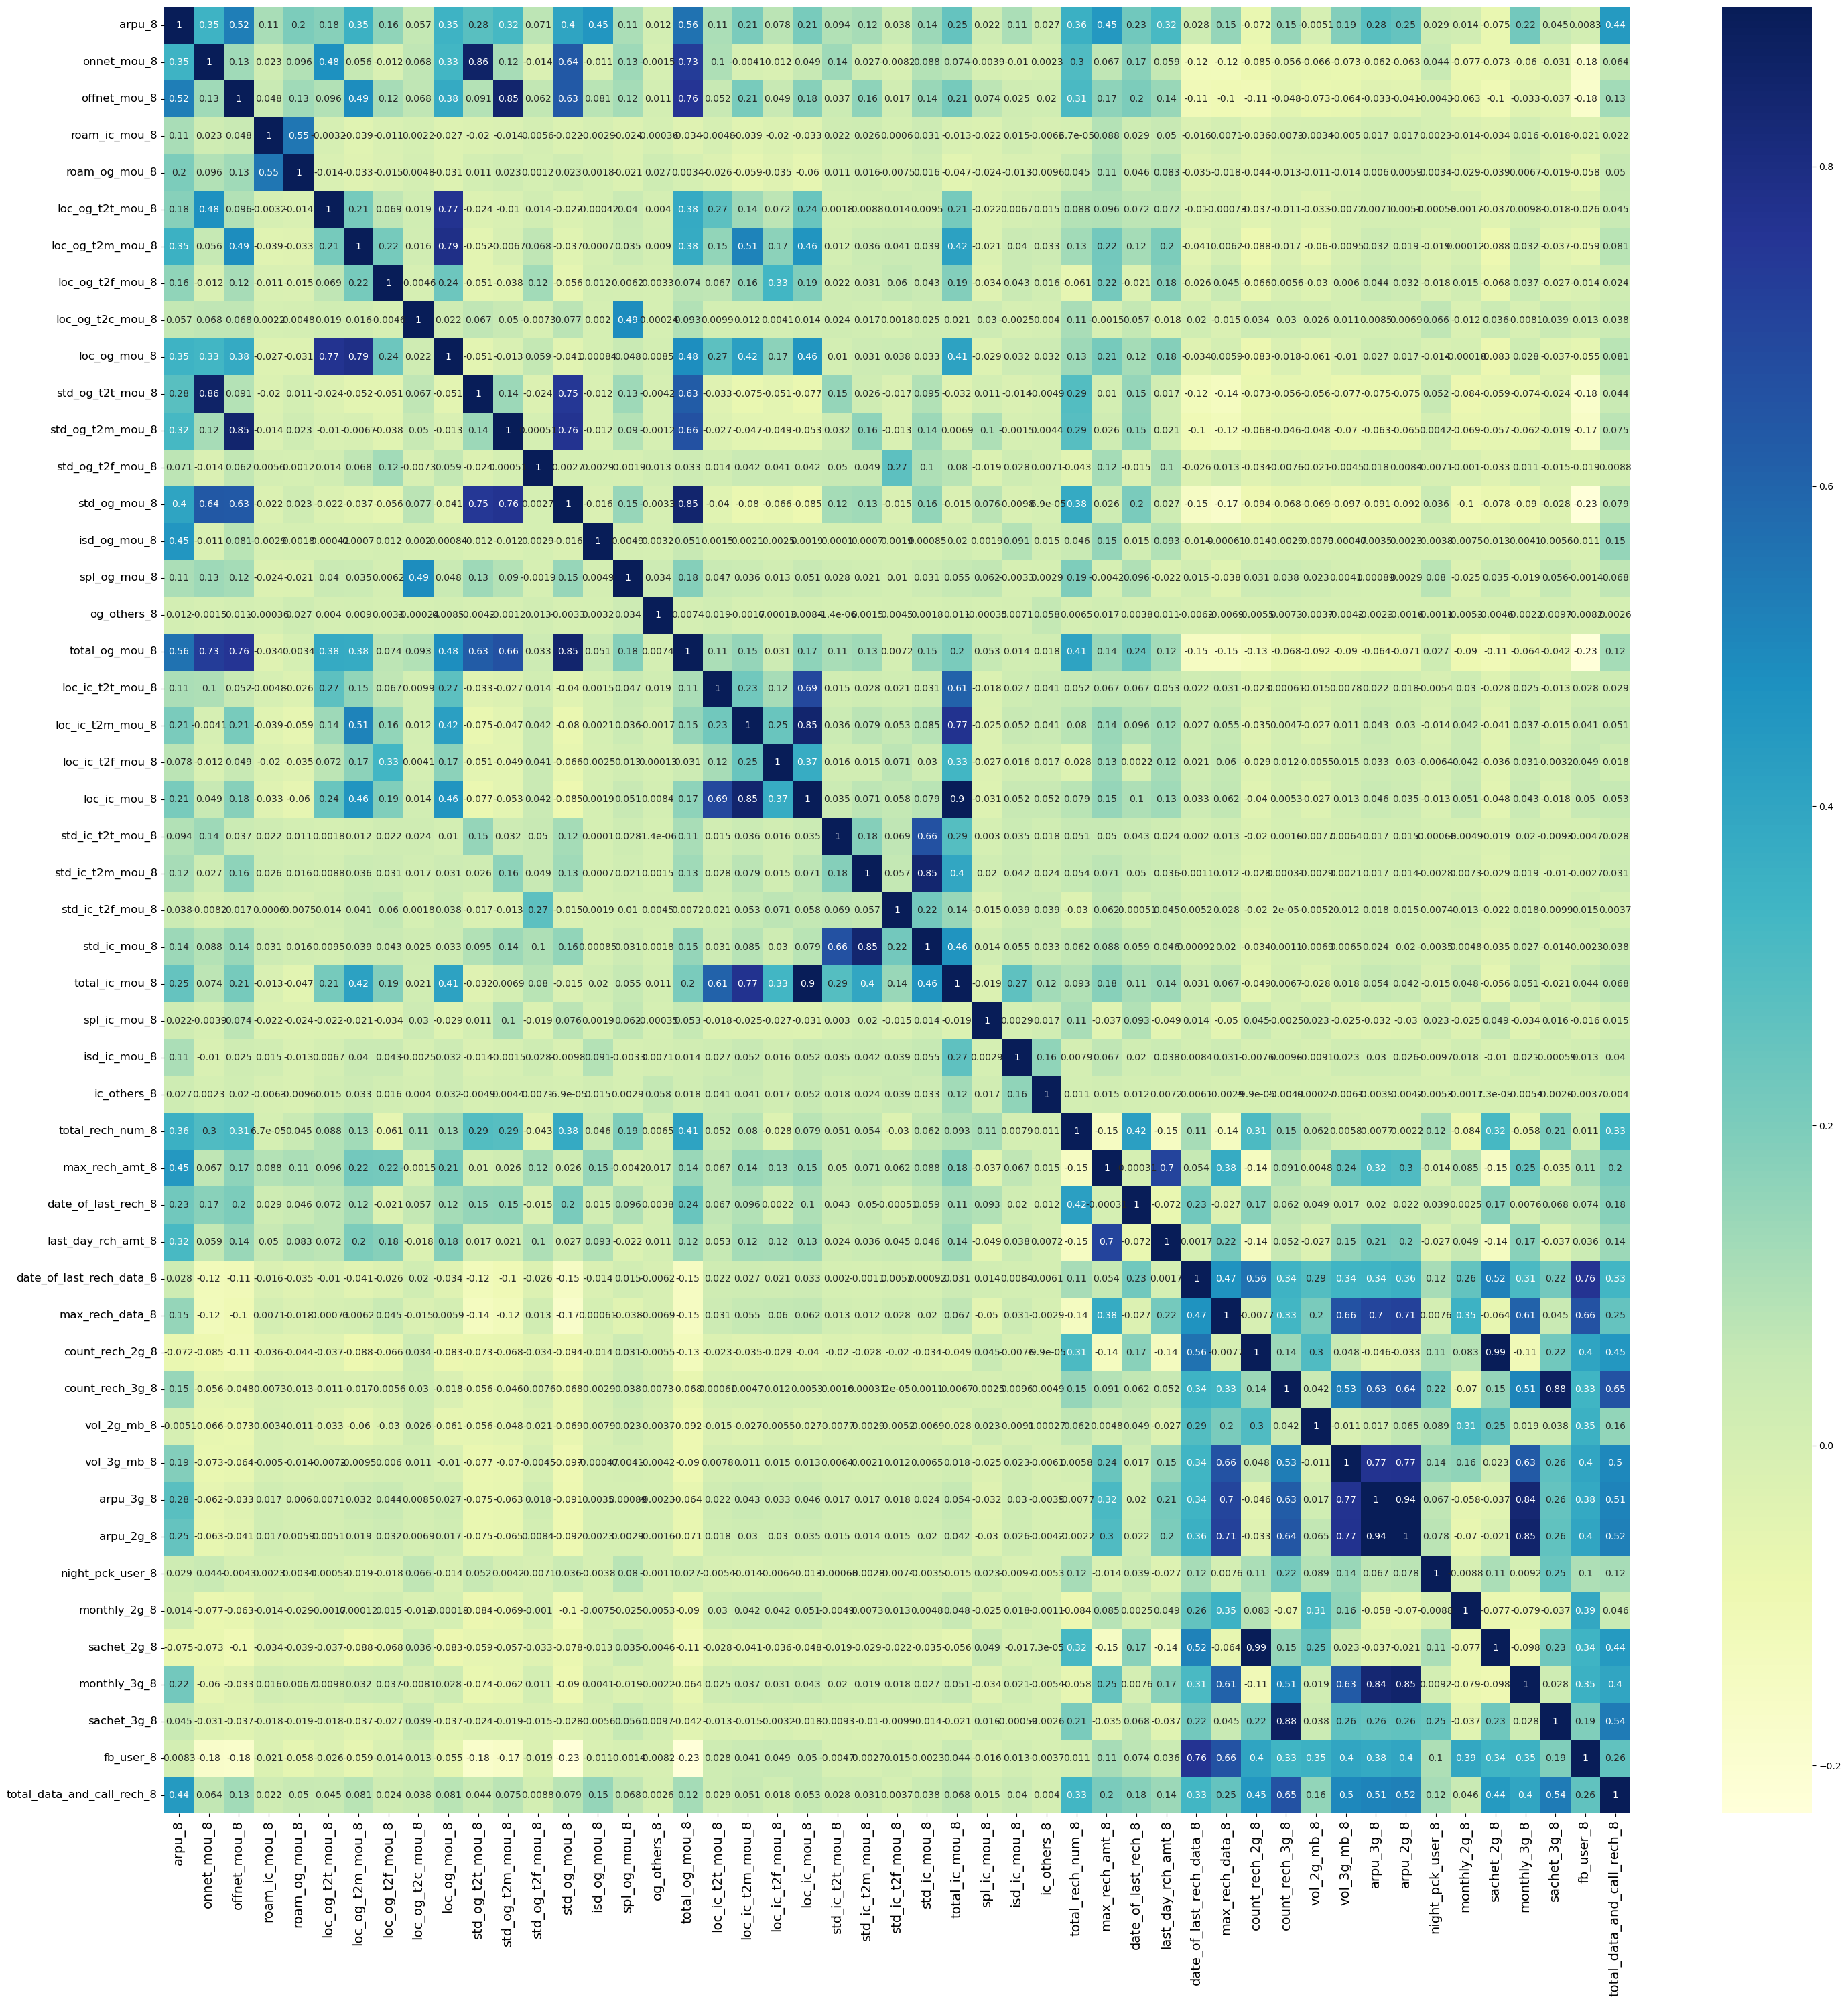

In [35]:
#To see the correlation between features and Churn, use a correlation map.
corrmat = data_8.corr()
plt.subplots(figsize=(30,30))
sns.heatmap(corrmat, cmap="YlGnBu", vmax=0.9,annot = True)
plt.xticks(size = 14)
plt.yticks(size = 12)
plt.tight_layout()
plt.show()

Since the correlation between total_ic_mou_8 and loc_ic_mou_8 is high—.9—most incoming voice calls are local calls.
There is a strong correlation (r = 0.99) between count_rech_2g_8 and sachet_2g_8; more 2g sachet purchases correspond to more 2g recharge.
There is a strong correlation (r = 0.88) between count_rech_3g_8 and sachet_3g_8; more 3g sachet purchases correspond to more 3g recharge. 
The correlation between arpu_3g_8 and arpu_2g_8 is high, 0.94.   


Deleting the original columns and merging the ones for average revenue from data usage and monthly data usage for both the "action" and "good times" phases.

In [36]:
data['arpu_2g_3g_6']= data['arpu_3g_6']+data['arpu_2g_6']
data['arpu_2g_3g_7']= data['arpu_3g_7']+data['arpu_2g_7']
data['arpu_2g_3g_8']= data['arpu_3g_8']+data['arpu_2g_8']

data['monthly_2g_3g_6']= data['monthly_3g_6']+data['monthly_2g_6']
data['monthly_2g_3g_7']= data['monthly_3g_7']+data['monthly_2g_7']
data['monthly_2g_3g_8']= data['monthly_3g_8']+data['monthly_2g_8']

data.drop(['total_ic_mou_6','total_ic_mou_7','total_ic_mou_8','monthly_3g_8','monthly_2g_8',
            'monthly_3g_6','monthly_2g_6','monthly_3g_7','monthly_2g_7',
            'arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7','arpu_2g_8',
            'count_rech_2g_6','count_rech_2g_7','count_rech_2g_8',
            'count_rech_3g_6','count_rech_3g_7','count_rech_3g_8',
           ],axis=1, inplace = True)

data.shape

(30001, 139)

In [37]:
# Examining the heatmap once more
cols = [c for c in data.columns if c[-2:] == '_8']
data_8=data[cols]
data_8.head()

arpu_8  onnet_mou_8  offnet_mou_8  roam_ic_mou_8  roam_og_mou_8  \
0   213.803        0.000         0.000          0.000          0.000   
7  3171.480       52.290       325.910         31.640         38.060   
8   137.362       35.080       136.480          0.000          0.000   
21  637.760       85.140       983.390          0.000          0.000   
23  366.966       33.580       205.890          0.000          0.000   

    loc_og_t2t_mou_8  loc_og_t2m_mou_8  loc_og_t2f_mou_8  loc_og_t2c_mou_8  \
0              0.000             0.000             0.000             0.000   
7             40.280           162.280            53.230             0.000   
8             12.490            50.540             0.000             7.150   
21            23.340           104.810             1.580             0.000   
23            33.580           148.560             0.000            17.710   

    loc_og_mou_8  ...  max_rech_data_8  vol_2g_mb_8  vol_3g_mb_8  \
0          0.000  ...          252.000        5.750      109.610   
7        255.790  ...            0.000        0.000        0.000   
8         63.040  ...           23.000        0.030       11.940   
21       129.740  ...            0.000        0.000        0.000   
23       182.140  ...          179.000        0.010     1009.920   

    night_pck_user_8  sachet_2g_8  sachet_3g_8  fb_user_8  \
0              0.000            0            0      1.000   
7              0.000            0            0      0.000   
8              0.000            3            0      1.000   
21             0.000            0            0      0.000   
23             0.000            0            1      1.000   

    total_data_and_call_rech_8  arpu_2g_3g_8  monthly_2g_3g_8  
0                      504.000       424.340                1  
7                     3638.000         0.000                0  
8                      327.000        19.830                0  
21                     718.000         0.000                0  
23                     979.000       347.940                1  

[5 rows x 44 columns]

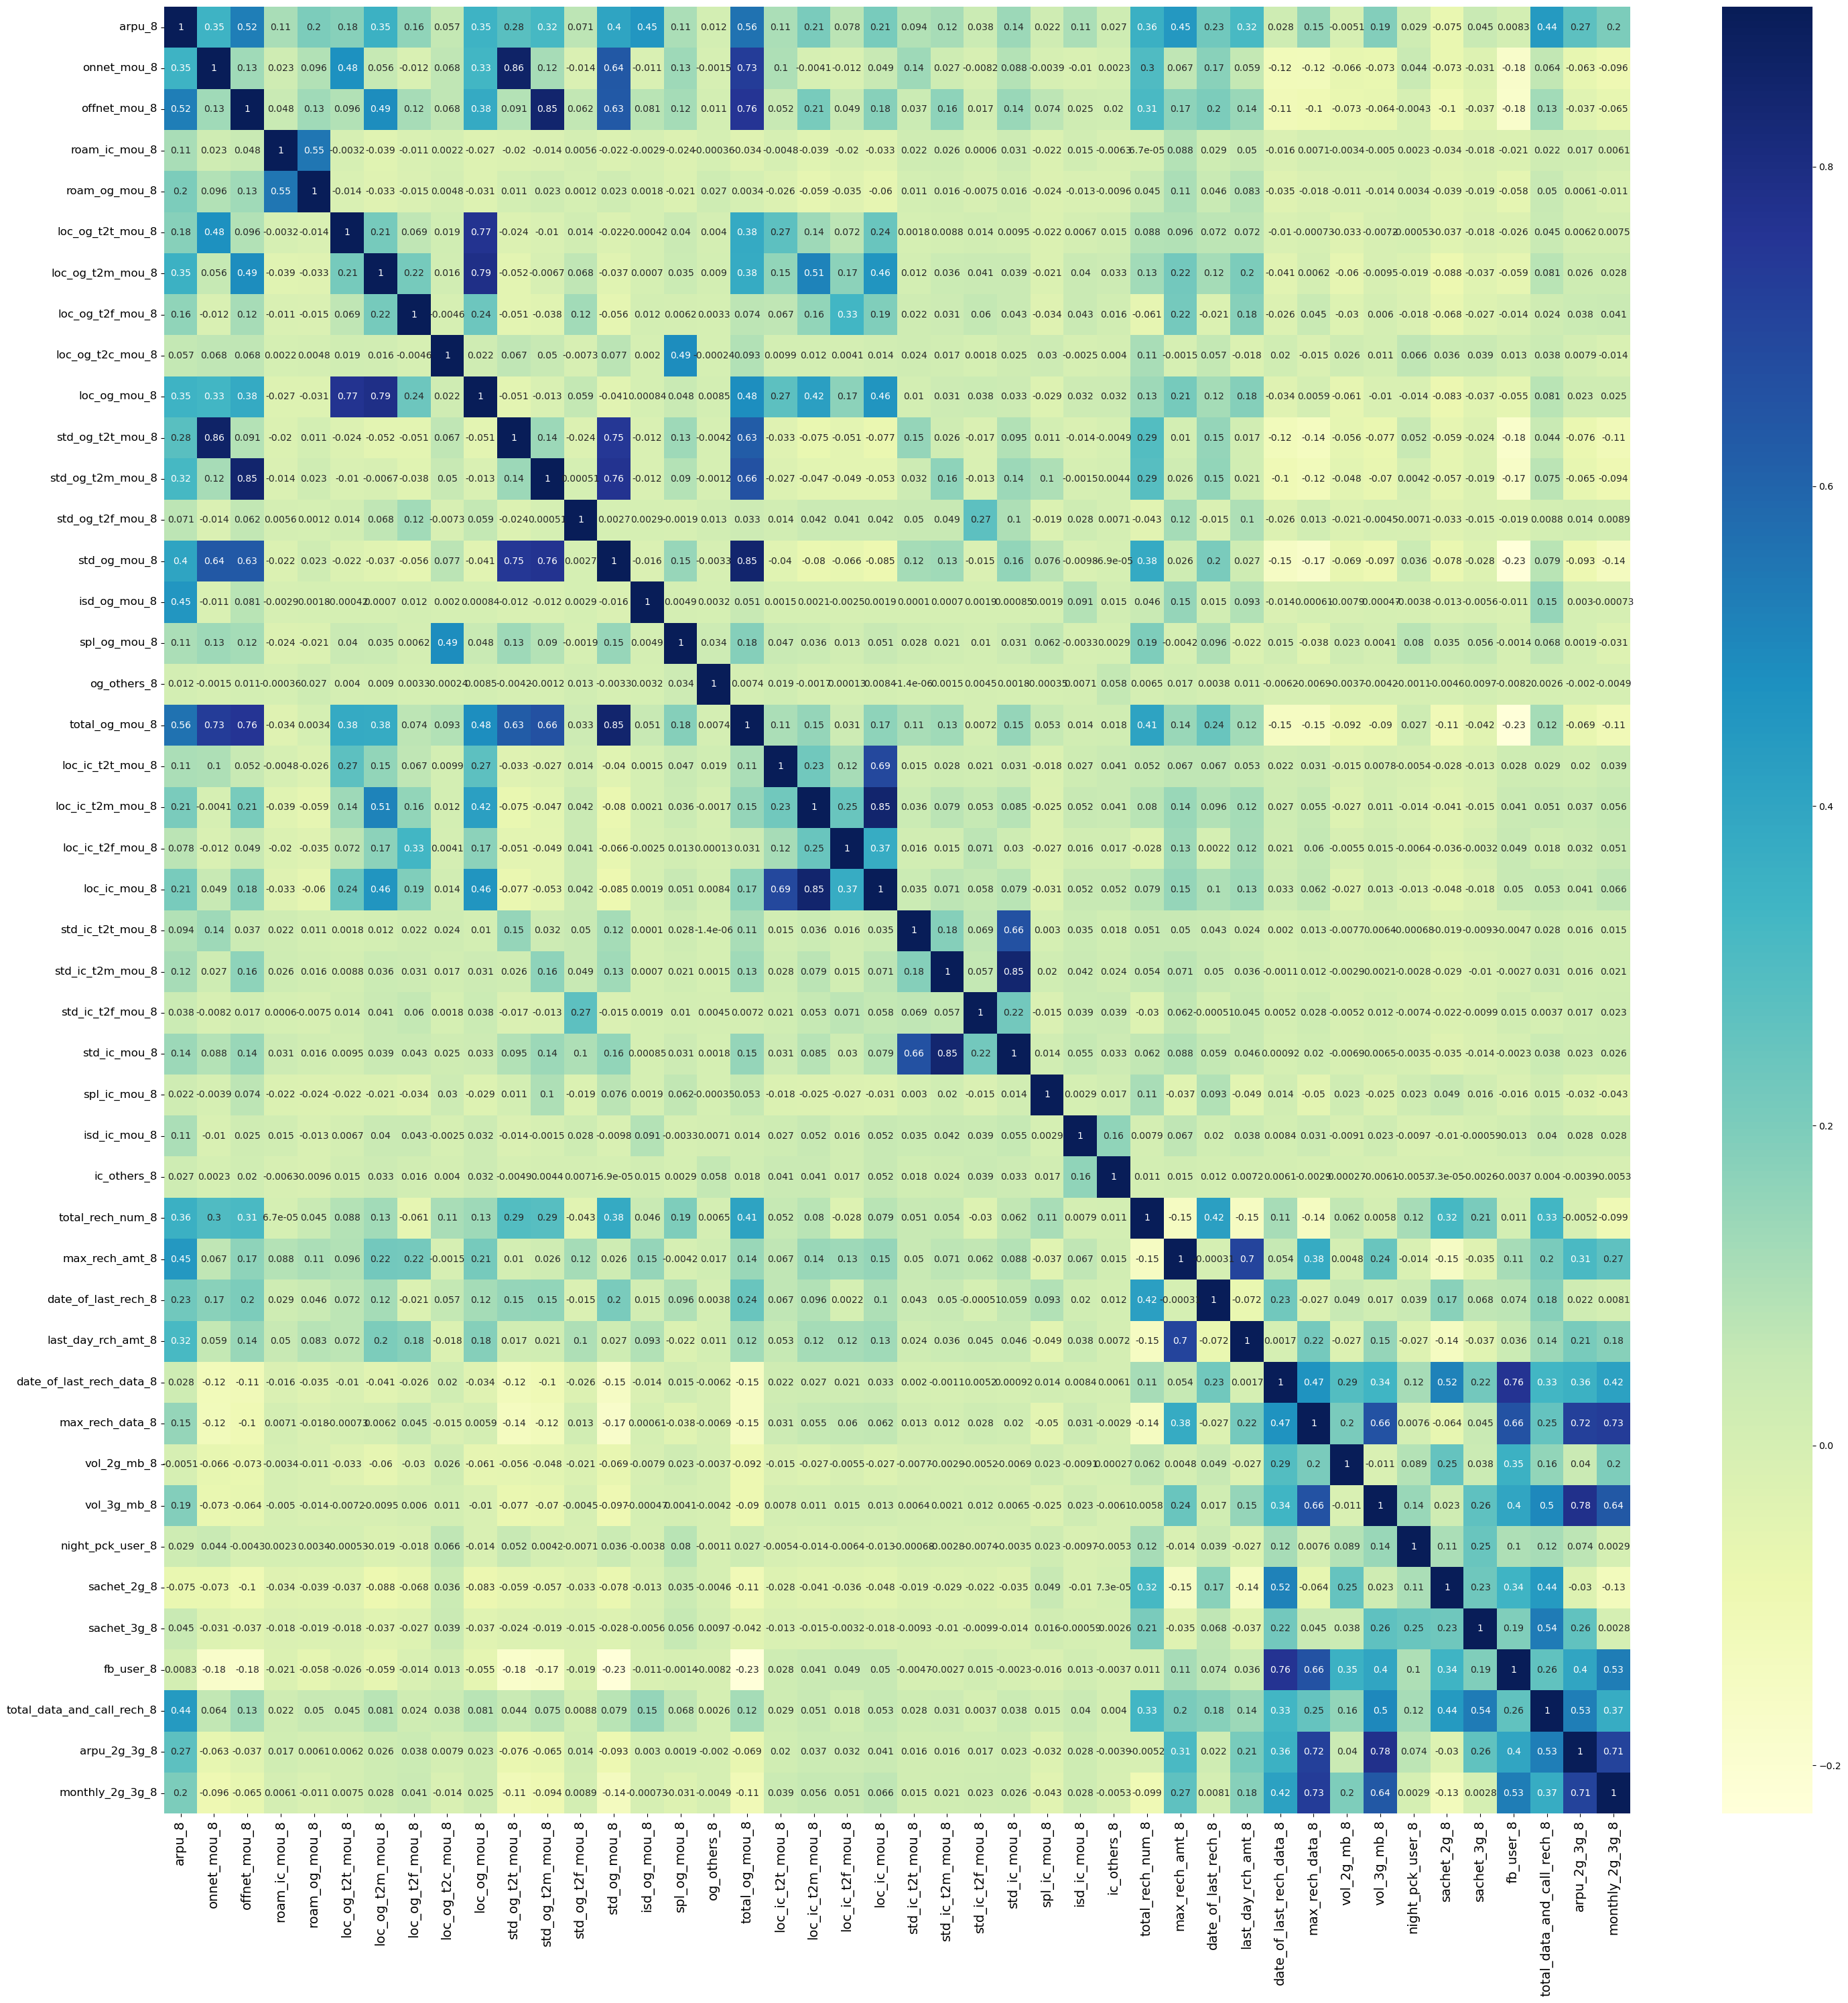

In [38]:
#To see the correlation between features and Churn, use a correlation map.
corrmat = data_8.corr()
plt.subplots(figsize=(30,30))
sns.heatmap(corrmat, cmap="YlGnBu", vmax=0.9,annot = True)
plt.xticks(size = 14)
plt.yticks(size = 12)
plt.tight_layout()
plt.show()

### Churn Rate

In [39]:
### Verifying the Conversion Rate of Leads
churned = (sum(data['churn'])/len(data['churn'].index))*100
churned

8.136395453484884

### Displaying the Churn Rate

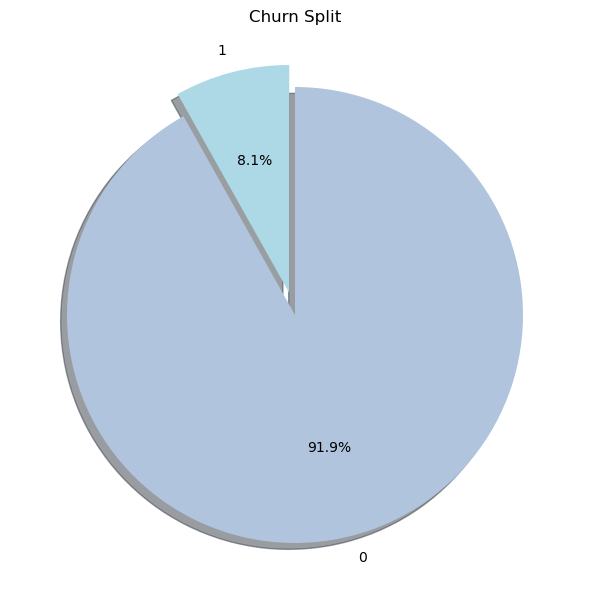

In [40]:
from collections import Counter

labels, values = zip(*Counter(data["churn"]).items())
colors = ['lightblue', 'lightsteelblue']
piechart_df = (pd.DataFrame(list(values),list(labels)))
piechart_df = piechart_df.reset_index()

fig = plt.figure(figsize=[6, 6])

plt.pie(piechart_df[0],labels=piechart_df["index"],startangle=90,explode=(0.1,0),autopct="%1.1f%%", shadow=True, colors=colors)
plt.tight_layout()
plt.title("Churn Split")
plt.show()

#### We have about 8% Churn Rate

In [41]:
# Counting the number of non-churn and churn customers
data.churn.value_counts()

0    27560
1     2441
Name: churn, dtype: int64

#### The churn rate is only 8%, indicating a significant class imbalance. Our classification models' low predictive accuracy for the minority class (churn class) will result from this. 

This implies that our predictive model won't be able to accurately identify customers who may leave.

### Oversampling the class of minorities

As a result, artificial samples of the minority class—not copies—will be produced. The minority class is now on par with the majority class as a result.

In [42]:
from sklearn.utils import resample

data_majority = data[data['churn']==0]
data_minority = data[data['churn']==1]

data_minority_upsampled = resample(data_minority,
replace=True,
n_samples=27560, 
random_state=1) 
data_upsampled = pd.concat([data_majority, data_minority_upsampled])

data_upsampled['churn'].value_counts()

0    27560
1    27560
Name: churn, dtype: int64

## Applying Test-Train Split

In [43]:
train, test = train_test_split(data_upsampled, test_size = 0.6)

X_train_upsampled = train.drop(['mobile_number','churn'], axis=1)
X_test_upsampled = test.drop(['mobile_number','churn'], axis=1)
y_train_upsampled = train['churn']
y_test_upsampled = test['churn']

print(X_train_upsampled.shape)
print(y_train_upsampled.shape)
print(X_test_upsampled.shape)
print(y_test_upsampled.shape)

(22048, 137)
(22048,)
(33072, 137)
(33072,)


In [44]:
print(y_train_upsampled.value_counts())
print(y_test_upsampled.value_counts())

0    11040
1    11008
Name: churn, dtype: int64
1    16552
0    16520
Name: churn, dtype: int64


## Applying Scaling Features

In [45]:
from sklearn.preprocessing import StandardScaler

In [46]:
# The feature variables are normalized using sklearn Standard Scaler.
scaler = StandardScaler()

X_train_upsampled = scaler.fit_transform(X_train_upsampled)
X_test_upsampled = scaler.transform(X_test_upsampled)

pd.DataFrame(X_test_upsampled).head()

0      1      2      3      4      5      6      7      8      9    ...  \
0 -0.232 -0.686 -0.289 -0.541 -0.542 -0.370 -0.630 -0.607 -0.460 -0.206  ...   
1 -0.846 -0.518 -0.390 -0.584 -0.550 -0.438 -0.703 -0.657 -0.529 -0.206  ...   
2 -1.112 -1.084  0.624 -0.583 -0.550 -0.044 -0.681 -0.638  2.413 -0.206  ...   
3 -0.570 -0.544 -0.704 -0.319 -0.437 -0.324 -0.567 -0.560 -0.553 -0.206  ...   
4 -0.619  0.073 -0.229 -0.536 -0.528 -0.377 -0.551 -0.567 -0.306 -0.206  ...   

     127    128    129    130    131    132    133    134    135    136  
0  0.484 -0.451 -0.194 -0.014 -0.329 -0.243 -0.154  2.338  0.976  1.296  
1 -0.580  2.910  0.645  1.508 -0.385 -0.312 -0.143  0.921  0.976  1.296  
2  1.406  0.656  2.715  1.199  1.018 -0.135  1.583  0.921  3.863  4.691  
3 -0.101 -0.553 -0.518 -0.405 -0.007 -0.354 -0.302 -0.495 -0.468 -0.401  
4 -0.483  0.916 -0.135  0.307 -0.311  0.072 -0.262  0.921  0.976 -0.401  

[5 rows x 137 columns]

## Adding PCA tn the data

In [47]:
X_train_upsampled.shape

(22048, 137)

In [48]:
#putting the PCA module in motion
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [49]:
#Applying PCA on the train data
pca.fit(X_train_upsampled)

PCA(random_state=42, svd_solver='randomized')

In [50]:
pca.n_components_

137

#### Plotting the main components will allow us to attempt to understand them.

In [51]:
pca.components_

array([[-6.01847273e-02, -5.92912103e-02, -2.16690127e-02, ...,
         1.55509253e-01,  1.60161574e-01,  1.55934715e-01],
       [ 1.01386137e-01,  1.71886945e-01,  2.14194943e-01, ...,
         5.64866420e-02,  8.45383742e-02,  1.02801948e-01],
       [ 5.63941822e-02,  1.03484756e-01,  8.47714576e-02, ...,
         6.08449946e-02,  7.84689283e-02,  7.24483883e-02],
       ...,
       [-2.04527671e-07,  7.06821086e-08, -1.40964380e-08, ...,
        -4.80519582e-08, -6.70684785e-08, -6.28863131e-08],
       [-1.34423219e-07,  2.01709241e-08, -1.69923549e-07, ...,
         3.47344453e-09,  5.41513773e-08, -3.86638139e-08],
       [-2.40299109e-16,  3.46887343e-17,  9.70322204e-17, ...,
        -4.92628836e-17, -4.65290870e-17, -2.91471019e-17]])

In [52]:
colnames = list(pd.DataFrame(X_train_upsampled).columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head()

PC1   PC2  Feature
0 -0.060 0.101        0
1 -0.059 0.172        1
2 -0.022 0.214        2
3 -0.136 0.048        3
4 -0.140 0.083        4

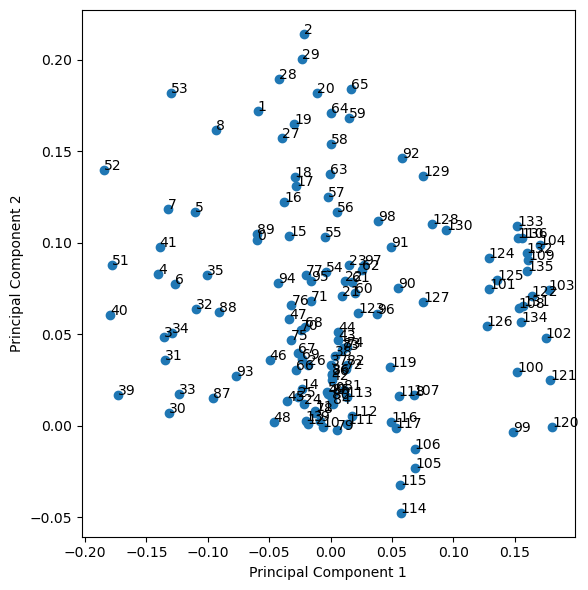

In [53]:
%matplotlib inline
fig = plt.figure(figsize = (6,6))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

#### examining the screeplot to determine how many principal components are required

In [54]:
pd.options.display.float_format = '{:.2f}'.format
pca.explained_variance_ratio_

array([9.68630590e-02, 8.22661677e-02, 5.73335662e-02, 4.33284365e-02,
       3.53952982e-02, 3.13320905e-02, 3.10823678e-02, 2.82765689e-02,
       2.56935076e-02, 2.27201953e-02, 2.20073206e-02, 2.00119136e-02,
       1.86867493e-02, 1.82524861e-02, 1.73620208e-02, 1.69628276e-02,
       1.65679768e-02, 1.56518334e-02, 1.44461431e-02, 1.40409205e-02,
       1.26147594e-02, 1.22857170e-02, 1.08844905e-02, 1.05994657e-02,
       1.00636803e-02, 9.82715397e-03, 9.40907432e-03, 9.16575098e-03,
       9.02032070e-03, 8.93115417e-03, 8.42056537e-03, 8.21048109e-03,
       8.14882916e-03, 7.69417084e-03, 7.44225489e-03, 7.22373658e-03,
       7.02476219e-03, 6.98594449e-03, 6.80600335e-03, 6.61346981e-03,
       6.38167860e-03, 6.19298549e-03, 5.93525081e-03, 5.82034287e-03,
       5.56799310e-03, 5.48118477e-03, 5.25030553e-03, 5.11964085e-03,
       5.01028369e-03, 4.83146831e-03, 4.78896930e-03, 4.56205233e-03,
       4.41931769e-03, 4.20857122e-03, 4.03966158e-03, 3.91703681e-03,
      

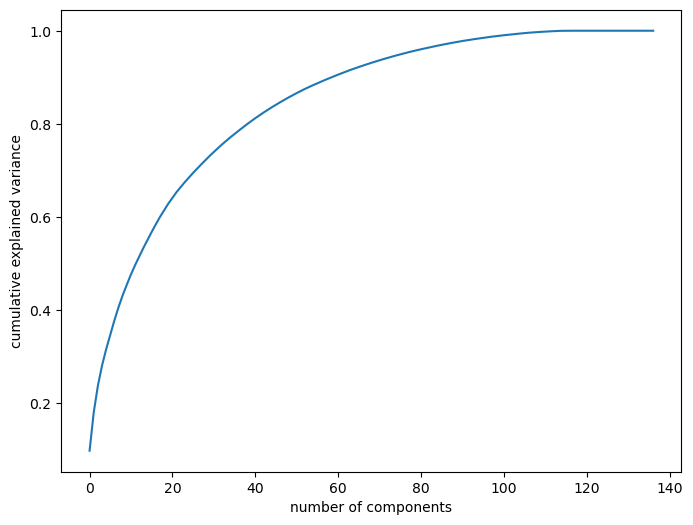

In [55]:
#Plotting the cumulative variance against the total number of components to create a screeplot
%matplotlib inline
fig = plt.figure(figsize = (8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

#### select the number of PCs so that the model accounts for 95% of the cumulative variance.

In [56]:
from sklearn.decomposition import PCA
pca_again = PCA(0.95)

In [57]:
#Using the train data for PCA
pca_again.fit(X_train_upsampled)

PCA(n_components=0.95)

In [58]:
pca_again.n_components_

77

#### It can be observed that out of the 137 features, only 78 features are needed to account for 95% of the cumulative variance in the model.

In [59]:
pca_again.components_

array([[-0.06018473, -0.05929121, -0.02166901, ...,  0.15550925,
         0.16016157,  0.15593472],
       [ 0.10138614,  0.17188694,  0.21419494, ...,  0.05648664,
         0.08453837,  0.10280195],
       [ 0.05639418,  0.10348476,  0.08477146, ...,  0.06084499,
         0.07846893,  0.07244839],
       ...,
       [ 0.04202698, -0.038689  ,  0.07733595, ..., -0.0397798 ,
        -0.00074539,  0.06238701],
       [-0.07747378, -0.06454804, -0.09624325, ...,  0.18287442,
        -0.04429508, -0.09340539],
       [ 0.03159322,  0.12039831, -0.01376946, ..., -0.1775861 ,
         0.04604516, -0.02037986]])

In [60]:
colnames = list(pd.DataFrame(X_train_upsampled).columns)
pcs_df = pd.DataFrame({'PC1':pca_again.components_[0],'PC2':pca_again.components_[1], 'Feature':colnames})
pcs_df.head()

PC1  PC2  Feature
0 -0.06 0.10        0
1 -0.06 0.17        1
2 -0.02 0.21        2
3 -0.14 0.05        3
4 -0.14 0.08        4

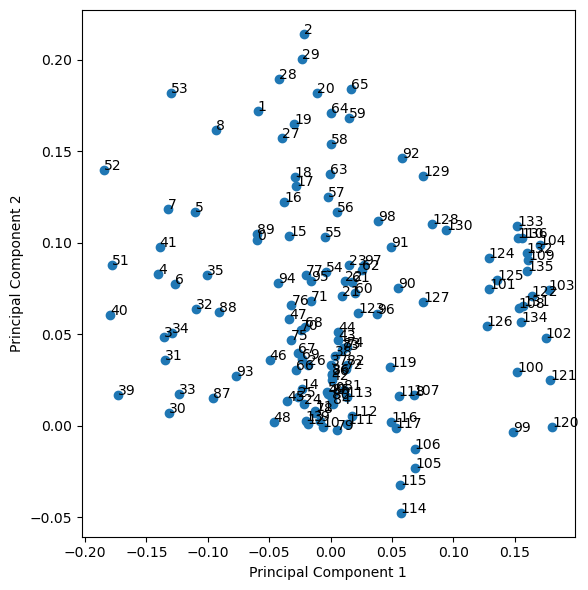

In [61]:
%matplotlib inline
fig = plt.figure(figsize = (6,6))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

In [62]:
X_train_upsampled_pca = pca_again.transform(X_train_upsampled)
X_test_upsampled_pca = pca_again.transform(X_test_upsampled)
X_train_upsampled_pca

array([[-4.98131282e+00, -4.61569698e-01,  1.40855583e+00, ...,
        -7.35412243e-01, -5.14539204e-01, -5.13130144e-01],
       [-1.20243143e+00, -2.26912146e+00, -2.25137098e-01, ...,
        -5.95369394e-02,  2.33433429e-01, -5.11568225e-02],
       [ 4.39763399e+00,  1.20939804e+00, -1.42147364e+00, ...,
         6.68314523e-01, -7.46467920e-01, -1.00916187e+00],
       ...,
       [-9.81476889e-01,  1.07350922e+01, -9.40294521e+00, ...,
        -1.90094185e+00,  2.94604859e+00,  2.89923901e-01],
       [ 2.20539857e+00, -3.68410007e+00, -3.85818413e-01, ...,
        -3.56949074e-03,  2.06034747e-01, -3.60793612e-01],
       [ 3.54714165e+00, -2.38408908e+00,  1.10350453e+00, ...,
        -3.37214485e-01,  6.96834331e-01, -1.03639732e+00]])

#### displaying data points according to the first and second principal components

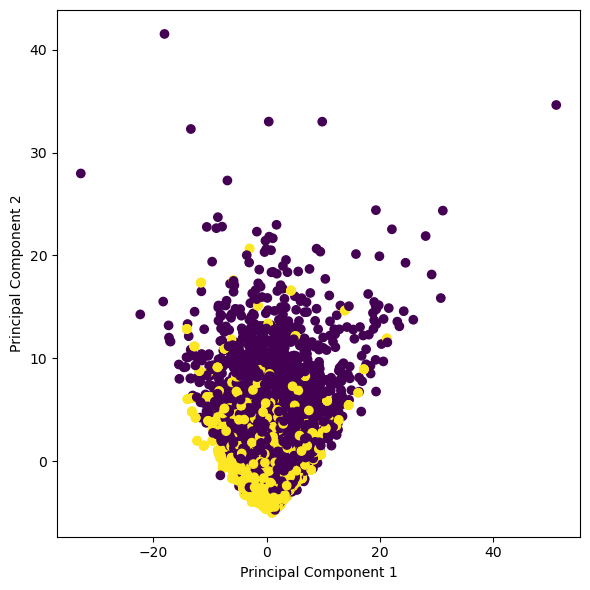

In [63]:
%matplotlib inline
fig = plt.figure(figsize = (6,6))
plt.scatter(X_train_upsampled_pca[:,0], X_train_upsampled_pca[:,1], c = y_train_upsampled)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

#### displaying data points according to the first, second, and third principal components

<IPython.core.display.Javascript object>


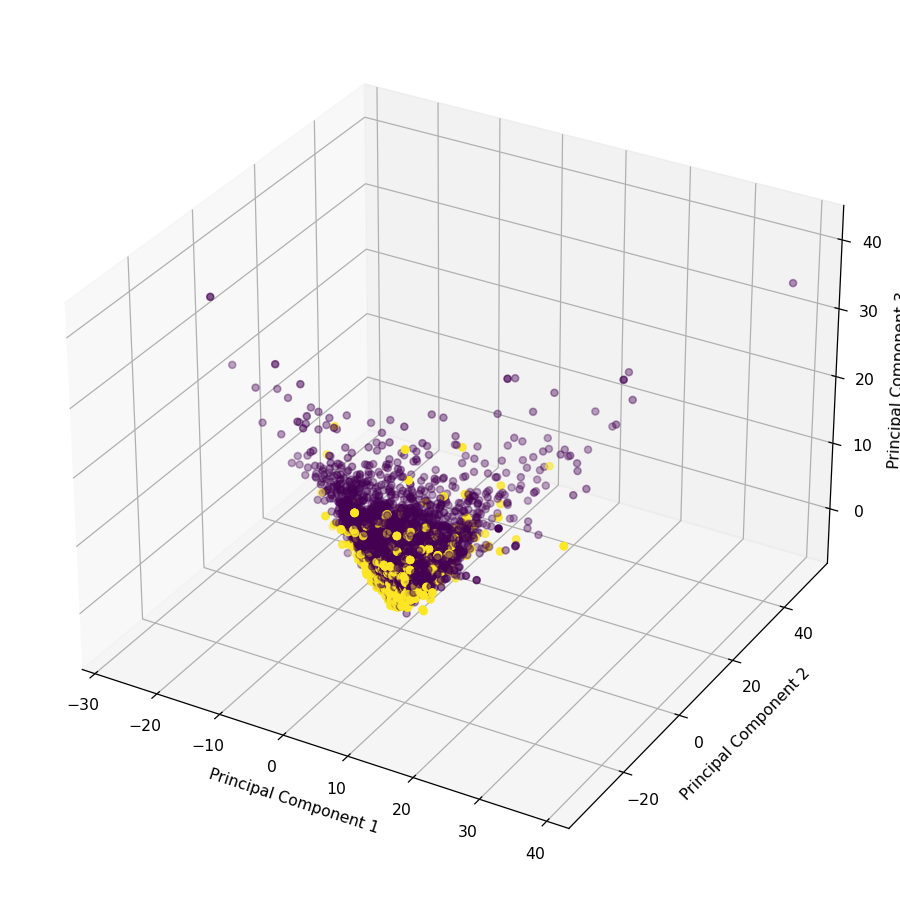

In [64]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
ax = plt.axes(projection='3d')
ax.scatter(X_train_upsampled_pca[:,2], X_train_upsampled_pca[:,0], X_train_upsampled_pca[:,1],zdir='z', s=20, marker = 'o', c=y_train_upsampled)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.tight_layout()
plt.show()

##  Model Building 
First, let's create a linear model using logistic regression and assess its accuracy.

accuracy: 0.8304305757135946
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     16520
           1       0.83      0.83      0.83     16552

    accuracy                           0.83     33072
   macro avg       0.83      0.83      0.83     33072
weighted avg       0.83      0.83      0.83     33072



<IPython.core.display.Javascript object>


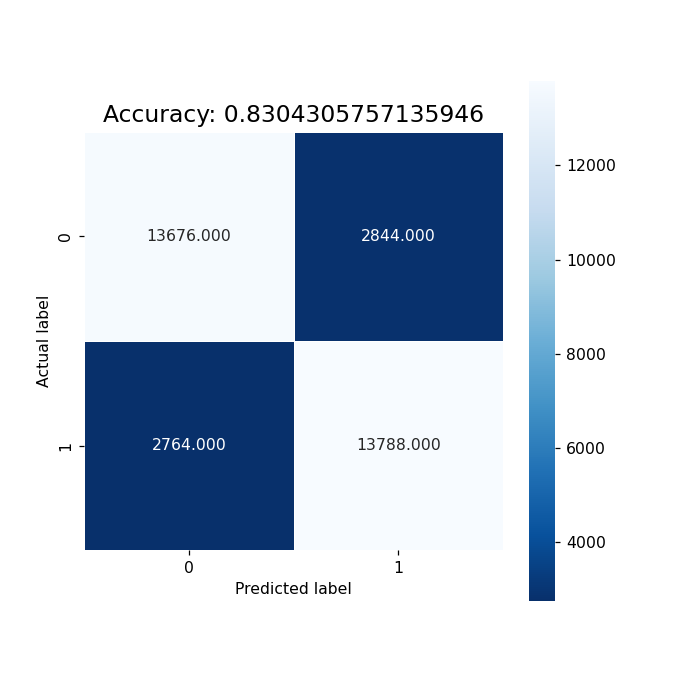

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
logisticRegr = LogisticRegression()
logisticRegr.fit(X=X_train_upsampled_pca, y=y_train_upsampled)

test_y_pred_balanced = logisticRegr.predict(X_test_upsampled_pca)
accuracy =  metrics.accuracy_score(y_test_upsampled, test_y_pred_balanced)
print("accuracy:", accuracy)
print(classification_report(y_test_upsampled, test_y_pred_balanced))

# Calculating confusion matrix
cmlr = metrics.confusion_matrix(y_true=y_test_upsampled, y_pred=test_y_pred_balanced)

# Plotting confusion matrix
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
sns.heatmap(cmlr, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Existing label');
plt.xlabel('Expected label');
all_sample_title = 'Accuracy: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);

In [66]:
TP = cmlr[1,1] # true positive 
TN = cmlr[0,0] # true negatives
FP = cmlr[0,1] # false positives
FN = cmlr[1,0] # false negatives

#### demonstrating the various metrics on the test dataset that go beyond accuracy

##### Sensitivity (TP / TP + FN)
#Let's examine our logistic regression model's sensitivity.
print("Sensitivity:", TP / float(TP+FN))

##### Specificity(TN / TN + FP)
print("Specificity:", TN / float(TN+FP))

##### False Postive Rate(FP / TN + FP)
print("False Postive Rate:", FP/ float(TN+FP))

##### Positive Predictive Value(TP / TP + FP)
print("Positive Predictive Value:", TP / float(TP+FP))

##### Negative Predictive Value(TN / TN + FN)
print("Negative Predictive Value:", TN / float(TN+ FN))

##### Precision(TP / TP + FP)
Precision = cmlr[1,1]/(cmlr[0,1]+cmlr[1,1])
print("Precision:", Precision)

##### Recall(TP / TP + FN)
Recall = cmlr[1,1]/(cmlr[1,0]+cmlr[1,1])
print("Recall:", Recall)

##### F1 = 2×(Precision*Recall)/(Precision+Recall)
F1 = 2*(Precision*Recall)/(Precision+Recall)
F1
print("F1 Score:", F1)

Sensitivity: 0.8330111164813919
Specificity: 0.8278450363196126
False Postive Rate: 0.1721549636803874
Positive Predictive Value: 0.829004329004329
Negative Predictive Value: 0.8318734793187348
Precision: 0.829004329004329
Recall: 0.8330111164813919
F1 Score: 0.8310028929604628


#### ROC Curve Plotting for the Test Dataset

In [67]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr,tpr, thresholds

In [68]:
fpr, tpr, thresholds = metrics.roc_curve( y_test_upsampled, test_y_pred_balanced, drop_intermediate = False )

In [69]:
draw_roc(y_test_upsampled, test_y_pred_balanced)

<IPython.core.display.Javascript object>

(array([0.        , 0.17215496, 1.        ]),
 array([0.        , 0.83301112, 1.        ]),
 array([2, 1, 0], dtype=int64))

### Area Under the Curve(GINI)

In [70]:
def auc_val(fpr,tpr):
    AreaUnderCurve = 0.
    for i in range(len(fpr)-1):
        AreaUnderCurve += (fpr[i+1]-fpr[i]) * (tpr[i+1]+tpr[i])
    AreaUnderCurve *= 0.5
    return AreaUnderCurve

In [71]:
auc = auc_val(fpr,tpr)
auc

0.8304280764005023

#### Thus, we obtain an accuracy of 0.83 using logistic regression. Let's try using non-linear models like Random Forest or SVM to see if we can raise the score.

## Model Building

let's create a non-linear model and adjust its hyperparameters using the default values.



#### Default Hyperparameters
First, let's fit a random forest model using the hyperparameters set to default.

In [72]:

from sklearn.ensemble import RandomForestClassifier

# using the default parameters when running the random forest.
rfc = RandomForestClassifier()

In [73]:
# fit
rfc.fit(X_train_upsampled_pca,y_train_upsampled)

RandomForestClassifier()

In [74]:
# Making predictions
predictions = rfc.predict(X_test_upsampled_pca)

In [75]:
#  examine our default model's report.

# importing the confusion matrix and classification report from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

print(classification_report(y_test_upsampled,predictions))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     16520
           1       0.96      0.99      0.98     16552

    accuracy                           0.98     33072
   macro avg       0.98      0.98      0.98     33072
weighted avg       0.98      0.98      0.98     33072



In [76]:
# Printing confusion matrix
print(confusion_matrix(y_test_upsampled,predictions))

[[15850   670]
 [   86 16466]]


In [77]:
print(accuracy_score(y_test_upsampled,predictions))

0.9771407837445574


#### Based on the default hyperparameters of Random Forest, we obtain an accuracy of 0.97. Let's adjust the hyperparameters and see if we can get better.

### Hyperparameter Tuning

### Tuning max_depth

Let us attempt to determine the ideal values for {{{max_depth{{{ and investigate the ways in which the value of max_depth affects the ensemble's overall accuracy.


It appears that as we increase max_depth, the training and test scores *both* seem to rise until a certain point before leveling off, and the model doesn't appear to overfit more.

## Finding the Ideal Hyperparameters with Grid Search

We can now use GridSearchCV to determine the ideal hyperparameters.

In [78]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [15, 25],
    'min_samples_leaf': range(10, 100, 50),
    'min_samples_split': range(10, 100, 50),
    'n_estimators': [100,200, 300], 
    'max_features': [4, 8]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

Fitting the final model using the grid search's optimal parameters.

In [79]:

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=25,
                             min_samples_leaf=10, 
                             min_samples_split=10,
                             max_features=4,
                             n_estimators=100)

In [80]:
# fit
rfc.fit(X_train_upsampled_pca,y_train_upsampled)

RandomForestClassifier(max_depth=25, max_features=4, min_samples_leaf=10,
                       min_samples_split=10)

In [81]:
# predict
predictions = rfc.predict(X_test_upsampled_pca)

accuracy: 0.9466618287373004
              precision    recall  f1-score   support

           0       0.96      0.93      0.95     16520
           1       0.93      0.96      0.95     16552

    accuracy                           0.95     33072
   macro avg       0.95      0.95      0.95     33072
weighted avg       0.95      0.95      0.95     33072



<IPython.core.display.Javascript object>


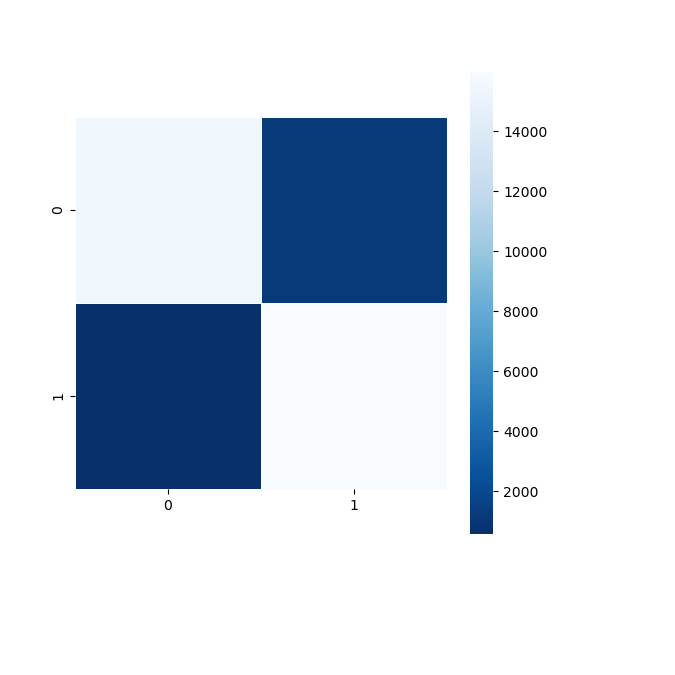

In [82]:
accuracy =  metrics.accuracy_score(y_test_upsampled, predictions)
print("accuracy:", accuracy)
print(classification_report(y_test_upsampled, predictions))

# Calculating confusion matrix
cmrf = metrics.confusion_matrix(y_true=y_test_upsampled, y_pred=predictions)

# Plotting confusion matrix
import matplotlib.pyplot as plt



plt.figure(figsize=(6,6))
sns.heatmap(cmrf, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);

In [83]:
TP = cmrf[1,1] # true positive 
TN = cmrf[0,0] # true negatives
FP = cmrf[0,1] # false positives
FN = cmrf[1,0] # false negatives

#### demonstrating the various metrics on the test dataset that go beyond accuracy

##### Sensitivity (TP / TP + FN)
print("Sensitivity:", TP / float(TP+FN))

##### Specificity(TN / TN + FP)
print("Specificity:", TN / float(TN+FP))

##### False Postive Rate(FP / TN + FP)
print("False Postive Rate:", FP/ float(TN+FP))

##### Positive Predictive Value(TP / TP + FP)
print("Positive Predictive Value:", TP / float(TP+FP))

##### Negative Predictive Value(TN / TN + FN)
print("Negative Predictive Value:", TN / float(TN+ FN))

##### Precision(TP / TP + FP)
Precision = cmrf[1,1]/(cmrf[0,1]+cmrf[1,1])
print("Precision:", Precision)

##### Recall(TP / TP + FN)
Recall = cmrf[1,1]/(cmrf[1,0]+cmrf[1,1])
print("Recall:", Recall)

##### F1 = 2×(Precision*Recall)/(Precision+Recall)
F1 = 2*(Precision*Recall)/(Precision+Recall)
F1
print("F1 Score:", F1)

Sensitivity: 0.9648380860318995
Specificity: 0.928450363196126
False Postive Rate: 0.07154963680387409
Positive Predictive Value: 0.9310867537313433
Negative Predictive Value: 0.9634422110552764
Precision: 0.9310867537313433
Recall: 0.9648380860318995
F1 Score: 0.9476619985758367


#### ROC Curve Plotting for the Test Dataset

In [84]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr,tpr, thresholds

In [85]:
fpr, tpr, thresholds = metrics.roc_curve( y_test_upsampled, predictions, drop_intermediate = False )

In [86]:
draw_roc(y_test_upsampled, predictions)

<IPython.core.display.Javascript object>

(array([0.        , 0.07154964, 1.        ]),
 array([0.        , 0.96483809, 1.        ]),
 array([2, 1, 0], dtype=int64))

###  Area Under the Curve(GINI)

In [87]:
def auc_val(fpr,tpr):
    AreaUnderCurve = 0.
    for i in range(len(fpr)-1):
        AreaUnderCurve += (fpr[i+1]-fpr[i]) * (tpr[i+1]+tpr[i])
    AreaUnderCurve *= 0.5
    return AreaUnderCurve

In [88]:
auc = auc_val(fpr,tpr)
auc

0.9466442246140128

#### The Random Forest model offers us an accuracy of 0.95 with the selected hyperparameters. With SVM models, let's see if we can improve any further.

##  SVM

First, let's create two simple models, one non-linear and the other linear, with default hyperparameters. Then, let's compare their accuracy.

In [89]:
# linear model

model_linear = SVC(kernel='linear')
model_linear.fit(X_train_upsampled_pca, y_train_upsampled)

# predict
y_test_pred = model_linear.predict(X_test_upsampled_pca)

In [90]:
# confusion matrix and accuracy

# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test_upsampled, y_pred=y_test_pred), "\n")
print(classification_report(y_test_upsampled, predictions))

accuracy: 0.834028785679729 

              precision    recall  f1-score   support

           0       0.96      0.93      0.95     16520
           1       0.93      0.96      0.95     16552

    accuracy                           0.95     33072
   macro avg       0.95      0.95      0.95     33072
weighted avg       0.95      0.95      0.95     33072



#### The linear model, like logistic regression, has an accuracy of about 84%. Now let's examine a sufficiently non-linear model whose hyperparameters are selected at random.

In [91]:

non_linear_model = SVC(kernel='rbf')

# fit
non_linear_model.fit(X_train_upsampled_pca, y_train_upsampled)

# predict
y_test_pred = non_linear_model.predict(X_test_upsampled_pca)

In [92]:
# confusion matrix and accuracy

# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test_upsampled, y_pred=y_test_pred), "\n")
print(classification_report(y_test_upsampled, predictions))

accuracy: 0.8946843251088534 

              precision    recall  f1-score   support

           0       0.96      0.93      0.95     16520
           1       0.93      0.96      0.95     16552

    accuracy                           0.95     33072
   macro avg       0.95      0.95      0.95     33072
weighted avg       0.95      0.95      0.95     33072



#### The accuracy of the non-linear model is approximately 91%. So let's select hyperparameters for non-linear models moving forward.

Now let's fine-tune the model to determine the ideal C and gamma values for an RBF kernel. Fourfold cross validation will be used.

In [94]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

In [95]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.60, 1.1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.60, 1.1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
plt.ylim([0.60, 1.1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

The following plots provide some helpful insights:
Completely/moderately linear models (very low to low gamma) perform *much worse* than non-linear models (with high gamma). The model does not typically overfit at high gamma values.  Performance is improved with a C of 100 at any given gamma value. 
This implies that both the problem and the data are **highly non-linear in nature**. In this situation, a complex model will perform better than a simple, linear model without overfitting.

Let's now choose the best hyperparameters. 

In [96]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

In [97]:
# model with optimal hyperparameters

# model
final_model = SVC(C=100, gamma=0.01, kernel="rbf")

final_model.fit(X_train_upsampled_pca, y_train_upsampled)
y_test_pred = final_model.predict(X_test_upsampled_pca)

# printing accuracy
accuracy =  metrics.accuracy_score(y_test_upsampled, y_test_pred)
print("accuracy:", accuracy)

# Printing classification report
print("classification_report:", classification_report(y_test_upsampled, y_test_pred))

# Calculating confusion matrix
cmsvm = metrics.confusion_matrix(y_true=y_test_upsampled, y_pred=y_test_pred)

# Plotting confusion matrix
import matplotlib.pyplot as plt


plt.figure(figsize=(6,6))
sns.heatmap(cmsvm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);

In [98]:
TP = cmsvm[1,1] # true positive 
TN = cmsvm[0,0] # true negatives
FP = cmsvm[0,1] # false positives
FN = cmsvm[1,0] # false negatives

#### Showcasing the different metrics beyond accuracy on the test dataset

##### Sensitivity (TP / TP + FN)
print("Sensitivity:", TP / float(TP+FN))

##### Specificity(TN / TN + FP)
print("Specificity:", TN / float(TN+FP))

##### False Postive Rate(FP / TN + FP)
print("False Postive Rate:", FP/ float(TN+FP))

##### Positive Predictive Value(TP / TP + FP)
print("Positive Predictive Value:", TP / float(TP+FP))

##### Negative Predictive Value(TN / TN + FN)
print("Negative Predictive Value:", TN / float(TN+ FN))

##### Precision(TP / TP + FP)
Precision = cmsvm[1,1]/(cmsvm[0,1]+cmsvm[1,1])
print("Precision:", Precision)

##### Recall(TP / TP + FN)
Recall = cmsvm[1,1]/(cmsvm[1,0]+cmsvm[1,1])
print("Recall:", Recall)

##### F1 = 2×(Precision*Recall)/(Precision+Recall)
F1 = 2*(Precision*Recall)/(Precision+Recall)
F1
print("F1 Score:", F1)

#### ROC Curve Plotting for the Test Dataset

In [99]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr,tpr, thresholds

In [100]:
fpr, tpr, thresholds = metrics.roc_curve( y_test_upsampled, y_test_pred, drop_intermediate = False )

In [101]:
draw_roc(y_test_upsampled, y_test_pred)

###  Area Under the Curve(GINI)

In [102]:
def auc_val(fpr,tpr):
    AreaUnderCurve = 0.
    for i in range(len(fpr)-1):
        AreaUnderCurve += (fpr[i+1]-fpr[i]) * (tpr[i+1]+tpr[i])
    AreaUnderCurve *= 0.5
    return AreaUnderCurve

In [103]:
auc = auc_val(fpr,tpr)
auc

#### Test accuracy with a nonlinear SVM model (selected hyperparameters) is 0.95.

## Step 11: Model Selection

Selection criteria for models: *<font color = blue>Accurately identifying churners is more crucial than non-churners.</font>*

Initially, we used a straightforward linear model called logistic regression before progressing to more intricate models.
 A brief synopsis of every model developed to forecast customer attrition is provided below
|Model|Accuracy|<font color = blue>Sensitivity</font>|Specificity|False Postive Rate|Positive Predictive Value|Negative Predictive value|Precision|Recall|F1 Score|AUC|
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|`Logistic Regression`|0.83|<font color = blue>0.84</font>|0.82|0.18|0.82|0.83|0.82|0.84|0.83|0.83|
|`Random Forest`|0.95|<font color = blue>0.96</font>|0.93|0.07|0.93|0.96|0.93|0.96|0.95|0.95|
|`SVM`|0.95|<font color = red>0.99</font>|0.91|0.09|0.92|0.99|0.92|0.99|0.95|0.95|

Initially, we used a straightforward linear model called logistic regression before progressing to more intricate models.A brief synopsis of every model developed to forecast customer attrition is provided below:In this context, sensitivity is defined as the total number of actual Churns that are correctly predicted out of all the actual Churns. It can also be known as {Recall} or {True Positive Rate}. Here, the objective is to more precisely identify the churners than the non-churners. Sensitivity is the evaluation metric that thus meets the business objective. The Support Vector Model, which can predict 99% of the customers who will churn, has the best value for Sensitivity, as can be seen in the above table.

Thus, the model we have selected is the SVM model.`

## Choosing Which Features Are Important

#### PCA was used during the construction of the earlier models. Determining the significance of features from these models will therefore be problematic.

In order to ascertain which features are most crucial in determining whether or not a customer will churn, we will be constructing a Decision Tree model based on the original feature set.

In [104]:
#train, test = train_test_split(data_upsampled, test_size = 0.6)
print(train.shape)
print(test.shape)

In [105]:
X_train_dt = train.drop(['mobile_number','churn'], axis=1)
X_test_dt = test.drop(['mobile_number','churn'], axis=1)
y_train_dt = train['churn']
y_test_dt = test['churn']

print(X_train_dt.shape)
print(y_train_dt.shape)
print(X_test_dt.shape)
print(y_test_dt.shape)

In [106]:
from sklearn.preprocessing import StandardScaler

In [107]:
# The feature variables are normalized using sklearn Standard Scaler.
scaler = StandardScaler()

X_train_dt = scaler.fit_transform(X_train_dt)
X_test_dt = scaler.transform(X_test_dt)

pd.DataFrame(X_train_dt).head()

In [108]:
# importing the Sklearn library's decision tree classifier
from sklearn.tree import DecisionTreeClassifier

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt_default = DecisionTreeClassifier(criterion = "gini", max_depth=5)
dt_default.fit(X_train_dt, y_train_dt)

In [109]:
# Let's look at our default model's evaluation metrics.

# Importing the confusion matrix and classification report from sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Making predictions
y_pred_default = dt_default.predict(X_test_dt)

# Printing classification report
print(classification_report(y_test_dt, y_pred_default))

In [110]:
# Printing confusion matrix and accuracy
print(confusion_matrix(y_test_dt,y_pred_default))
print(accuracy_score(y_test_dt,y_pred_default))

### The Decision Tree Plot

In [111]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

# Putting features into a variable
features = list(train.drop(['mobile_number','churn'], axis=1).columns[:])
features

In [112]:
# plotting tree with max_depth=3
dot_data = StringIO()  
export_graphviz(dt_default, out_file=dot_data,
                feature_names=features, filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#### putting the features' gini scores on display

In [113]:
# Capturing the feature importances from the tree model properties into a dataframe and seleting the top 10 features
feature_importance = dt_default.feature_importances_
fi = pd.concat([pd.DataFrame(features), pd.DataFrame(feature_importance)], axis = 1)
fi.columns = ['Features','Importance']
fi_sorted = fi.loc[fi['Importance']>0].sort_values(by=['Importance'],ascending=False)
fi_sorted_top10 = fi_sorted.head(10)
fi_sorted_top10

### Visually Determining the Leading Churn Indicators.

In [114]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(15,8), dpi=80, facecolor='w', edgecolor='k', frameon='True')
pal = ["#ff9999", "#99d8c9", "#2ca25f", "#8856a7","#66b3ff","#fdbb84","#e34a33","#bdbdbd","#f7fcb9","#99ff99","#f7fcb9","#fec44f","#d95f0e","#dd1c77","#99ff99"]
names = list(fi_sorted_top10.Features)
explode = (0.1, 0.1, 0.1, 0.1,0.1,0.1,0.1,0.1,0.1,0.1)

# subplot 1
plt.subplot(1, 2, 1)
patches, texts, autotexts = plt.pie(fi_sorted_top10['Importance'], labels=names, startangle=235, colors = pal, autopct='%.1f%%',shadow=True,explode=explode)
plt.title("Percentage Importance of Top 10 Indicators of churn",fontsize=12)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  
for autotext in autotexts:
    autotext.set_color('blue')

# subplot 2
plt.subplot(1, 2, 2)
sns.barplot(y='Features', x='Importance', palette='coolwarm', data=fi_sorted, estimator=np.sum)
plt.yticks(size = 10)
plt.title("Importance of Features in data Churn",fontsize=12)
plt.xlabel('Importance', fontsize = 12, color='r')
plt.ylabel('Features', fontsize = 12, color='r')

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()


## Concluding remarks and suggestions

#### <font color = blue>According to GINI Scores, the top 10 indicators of customer churn are listed below.:</font>

|Features|	Importance|
|------|---------|
|loc_ic_mou_8|	0.561|
|	roam_og_mou_8|	0.083|
|	date_of_last_rech_8|	0.071|
|	fb_user_8|	0.070|
|	total_rech_num_7|	0.036|
|	std_og_mou_7|	0.028|
|	last_day_rch_amt_8|	0.027|
|	total_data_and_call_rech_8|	0.026|
|	total_og_mou_8|	0.025|
|	date_of_last_rech_data_8|	0.023|

#### <font color = blue>Observations & Recommendations:</font>

The majority of the indicators are features for either the second half of the good phase ({July}) or the action phase ({August}).
 The action phase's `Local Incoming minutes of usage` is more significant than the sum of the other features. This indicates that the likelihood of customers quitting is high if they do not receive local incoming calls. 
 Expensive `Roaming` fees, both inbound and outbound, are a significant contributing factor to attrition. Eye-catching roaming packs have the potential to make a customer reconsider switching service providers.

High-cost `Roaming` charges are a major cause of attrition, both inbound and outbound. Attractive roaming packs have the power to prevent a customer from deciding to switch service providers.
 Special `Facebook packs` are offered as perks by most data companies. I suggest the data provider offer a dedicated internet bundle for social media platforms aimed at premium clients.
 Two more motivating factors are {STD and ISD}. The majority of rivals provide compelling deals for ISD and STD calls. The data company must match these benefits and begin to package these services.